In [1]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 16, 3  # делаем картинки крупнее
%config InlineBackend.figure_format = 'retina'  # делаем картинки красивее

rg = np.random.RandomState(179)

Допустим, есть несколько точек из нормального распределения, и ещё немного из равномерного на отрезке [-10, 10] - какая-то модель данных с аномалиями

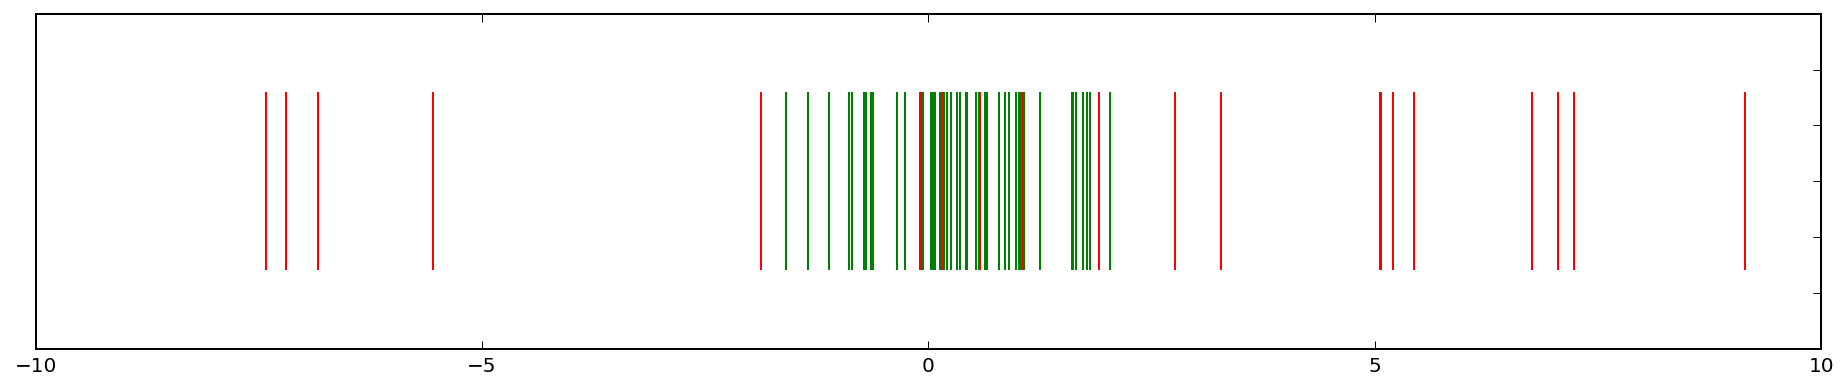

In [2]:
def show(normal, anomaly, xlim=10):
    plt.scatter(normal, np.zeros_like(normal), marker='|', c='green', s=8000)
    plt.scatter(anomaly, np.zeros_like(anomaly), marker='|', c='red', s=8000)
    plt.tick_params(axis='y', left='off', labelleft='off')
    plt.xlim(-xlim, xlim)
    plt.show()

normal = rg.randn(50)
anomaly = rg.uniform(-10, 10, 20)
show(normal, anomaly)

Имея в распоряжении только набор чисел, как по-хорошему должен алгоритм решать эту задачу? Очевидно, в центре есть кластер, это нормальные данные. Слева от кластера есть несколько полос (из которых на самом деле красная только самая левая, но ему это неизвестно) - вообще, пропустить аномалию критичнее, чем назвать аномалиями пару нормалий. Справа же ситуация выглядит проще, где явные аномалии визуально отделены, а спрятавшиеся слишком спрятаны.

Попробуем алгоритмизировать термин "визуально" - речь идёт о расстояниях между числами в наборе.

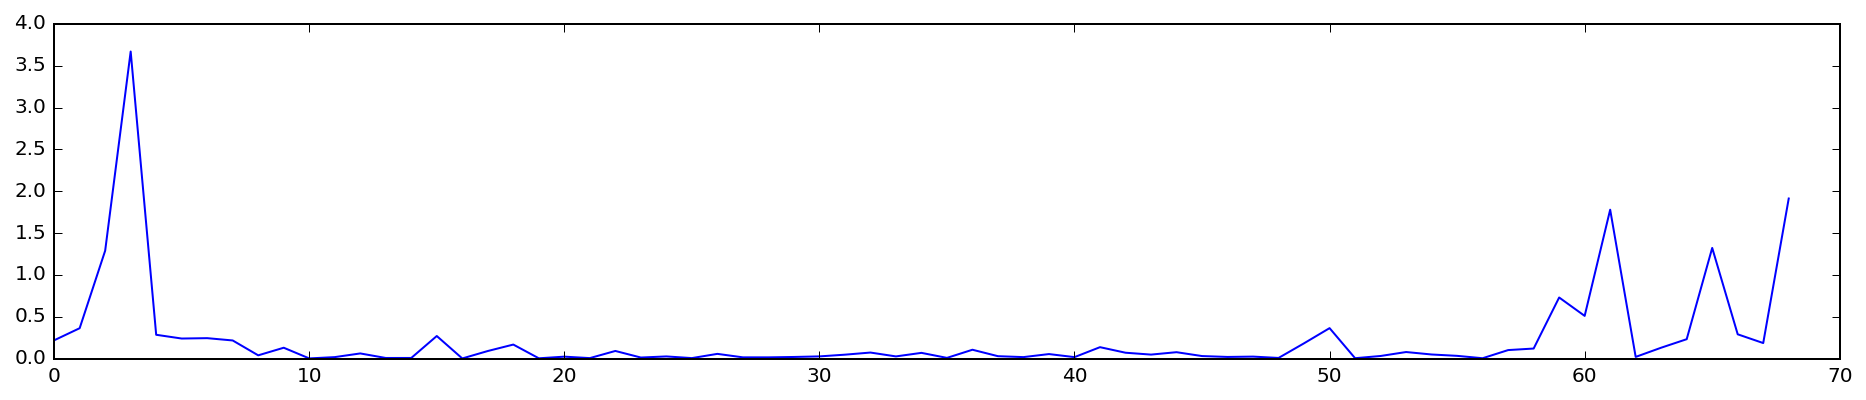

In [3]:
all_points = np.sort(np.append(normal, anomaly))
differences = all_points[1:] - all_points[:-1]
plt.plot(differences)

Кажется логичным простой подход: берём максимум. Этот максимум соответствует двум точкам, расстояние между которыми максимально. Таким образом, всё множество точек разбивается на две группы. Процедуру можно продолжать, но самое интересное - когда останавливаться - неочевидно.

Момент останова проще определить, если что-то известно: что кластер один, или то, "что он в серединке". Однако, как я уже писал, это не так интересно, и хочется решить задачу в общем случае. Отмечу только следующие очевидные утверждения:
- в случае обучения только на нормалиях или на размеченных данных эти точки можно добавить в разбиваемое множество.
- более того, таким образом можно пытаться определять, насколько глубоко стоит делать разбиения.
- например, интересна справедливость следующего предположения: останавливаться надо в тот момент, когда очередная точка разбивает группу, которая (согласно размеченным данным) относилась к нормалиям. Иными словами, между любыми соседними точками в кластерах нормалий разница меньше чем от определённых алгоритмом аномалий до определённых алгоритмом кластера нормалий.

Интересное предположение, надо будет попробовать. Потому что можно исходить и из каких-то других предположений! Например, нормальные числа - это которые целые, а всё остальное это аномалии! С постановкой вида "ну вот на прямой надо отделить одно от другого..." и такой ответ может оказаться правильным, но я пока посматриваю на случай, когда этими числами на прямой являются разумные признаки или anomaly_score. 

Поэтому допустим пока, что вообще никакой информации о цвете палочек нету, кроме подобных разумных и совершенно общих допущений

In [4]:
thresholds = (all_points[:-1] + differences / 2)[np.argsort(differences)[::-1][:1]]

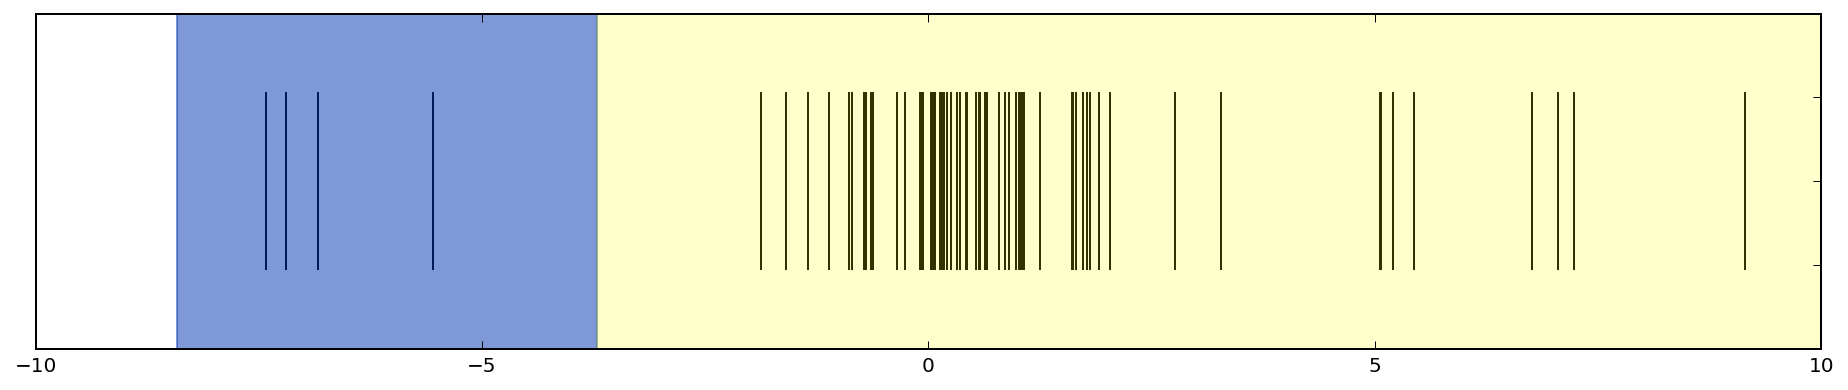

In [5]:
def draw(all_points, thresholds):
    thresholds = np.append(thresholds, all_points.max() + 1)
    currentAxis = plt.gca()
    start = all_points.min() - 1
    colors = [(0, 0.2, 0.7, 0.5), (1, 1, 0, 0.2)]
    for i in np.arange(len(thresholds)):
        new_one = np.sort(thresholds)[i]
        currentAxis.add_patch(plt.Rectangle((start, -1), new_one - start, 2, color=colors[i%2]))
        start = new_one
    
    plt.scatter(all_points, np.zeros_like(all_points), marker='|', c='black', s=8000)
    plt.tick_params(axis='y', left='off', labelleft='off')
    plt.ylim(-1, 1)
    plt.xlim(-10, 10)
    plt.show()

draw(all_points, thresholds)

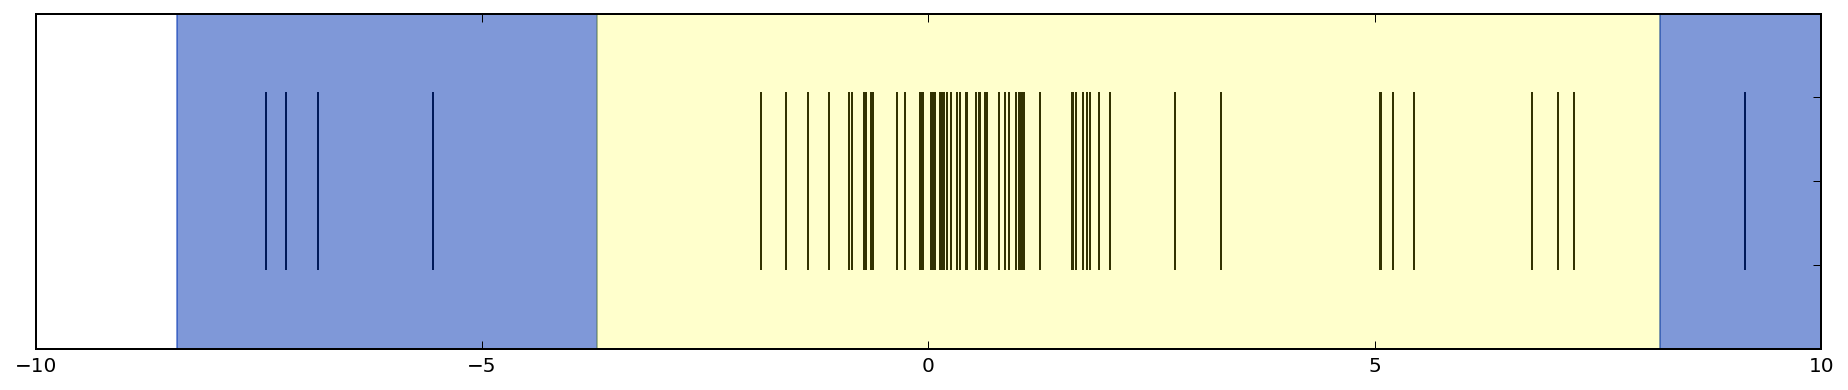

In [6]:
thresholds = (all_points[:-1] + differences / 2)[np.argsort(differences)[::-1][:2]]
draw(all_points, thresholds)

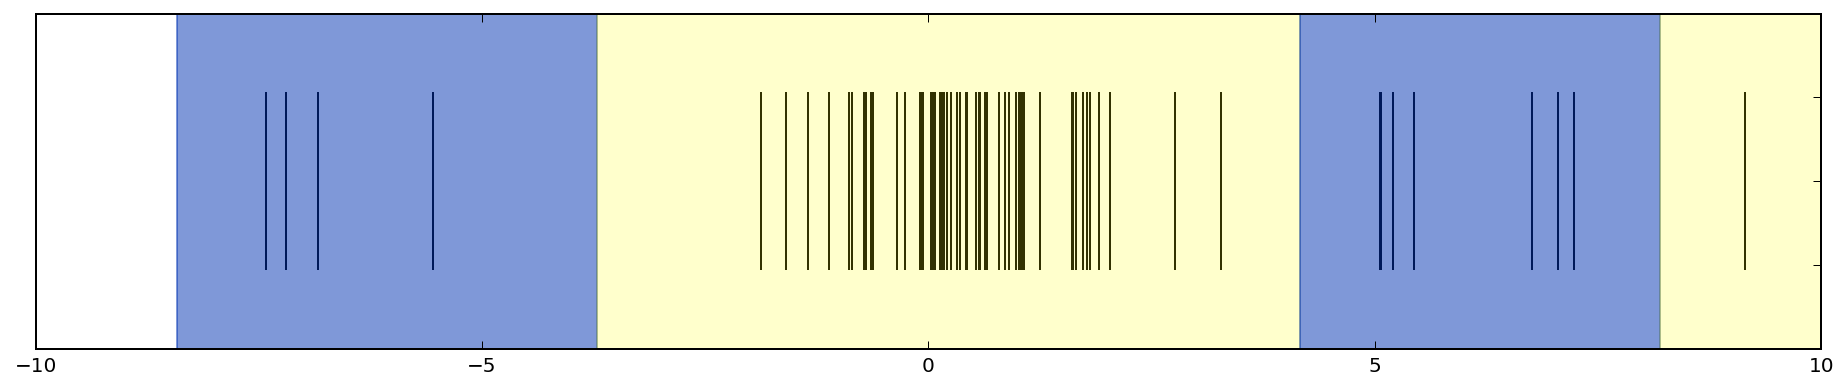

In [7]:
thresholds = (all_points[:-1] + differences / 2)[np.argsort(differences)[::-1][:3]]
draw(all_points, thresholds)

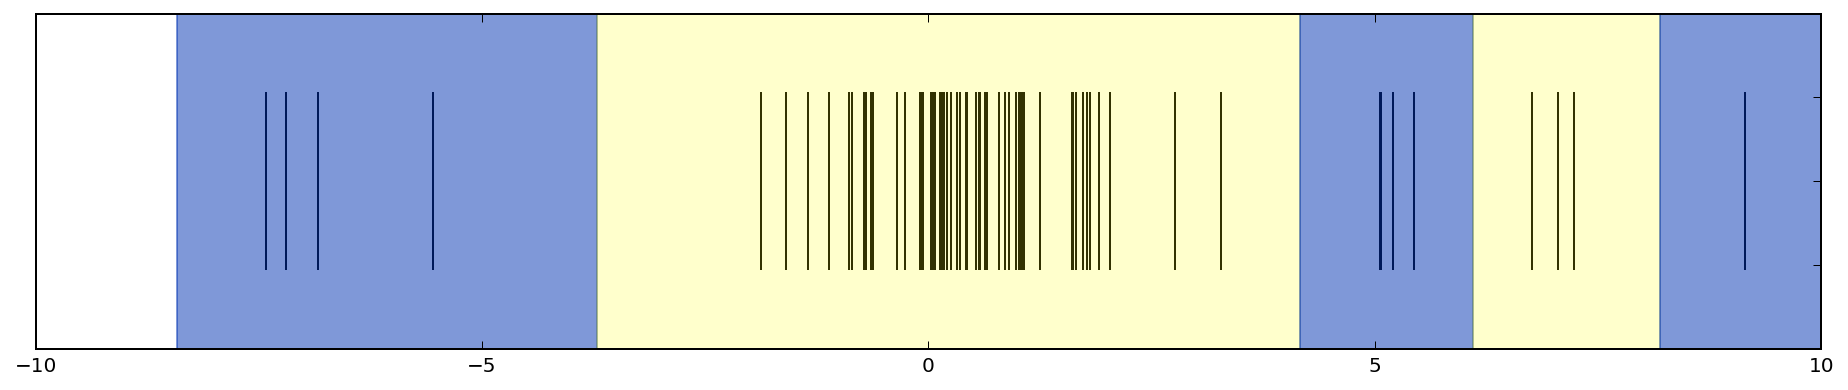

In [8]:
thresholds = (all_points[:-1] + differences / 2)[np.argsort(differences)[::-1][:4]]
draw(all_points, thresholds)

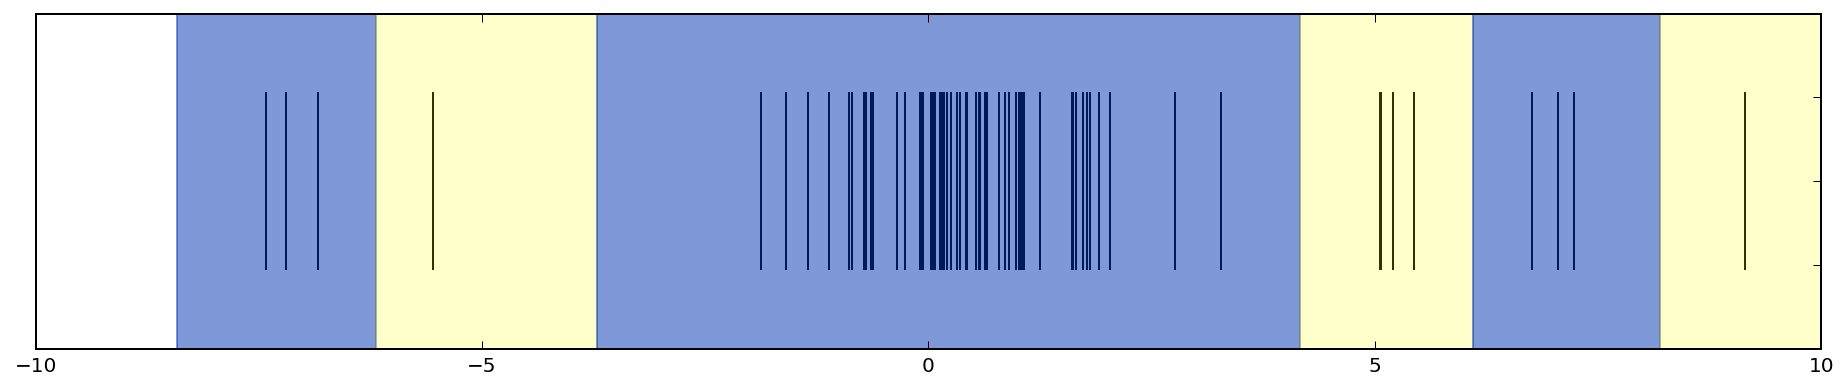

In [9]:
thresholds = (all_points[:-1] + differences / 2)[np.argsort(differences)[::-1][:5]]
draw(all_points, thresholds)

how far to go...

 how much to split...
 
how it is known

 how deep build trees!

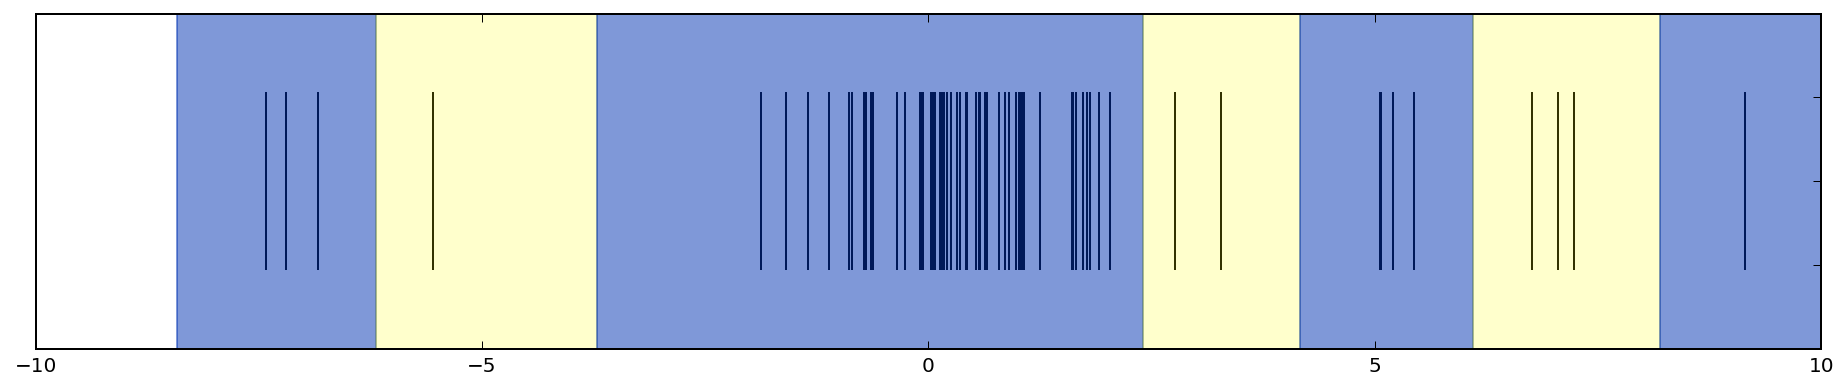

In [10]:
thresholds = (all_points[:-1] + differences / 2)[np.argsort(differences)[::-1][:6]]
draw(all_points, thresholds)

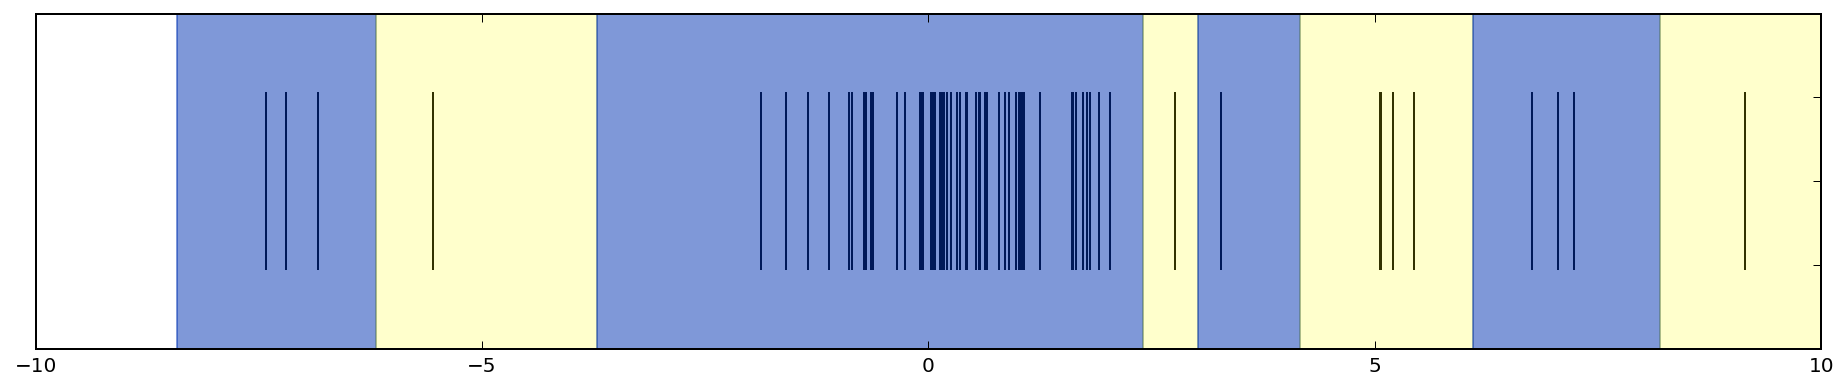

In [11]:
thresholds = (all_points[:-1] + differences / 2)[np.argsort(differences)[::-1][:7]]
draw(all_points, thresholds)

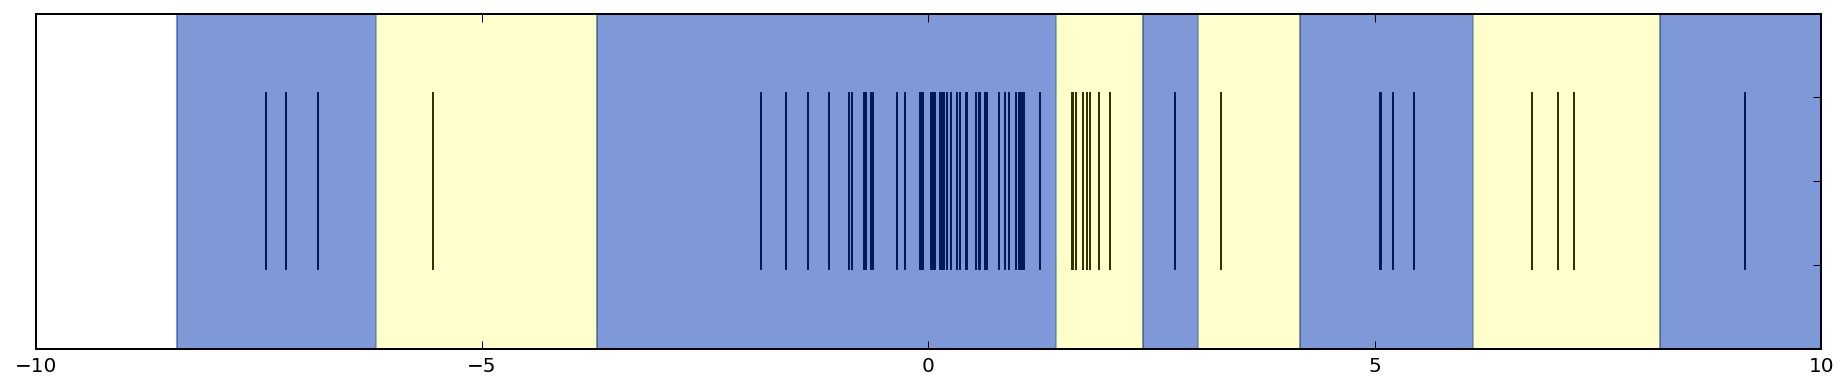

In [12]:
thresholds = (all_points[:-1] + differences / 2)[np.argsort(differences)[::-1][:8]]
draw(all_points, thresholds)

Теперь попробуем понять, почему это момент остановки!

1) На этом последнем шаге было отделено достаточно много объектов, то есть произошло одну из двух: либо произошло разделение на два кластера, между которыми не было аномалий, либо это уже ошибочный сплит.

2) Допустим, сплит корректен. Тогда: 1) соседние группы не могут быть обе группами нормалий 2) группы нормалий содержат больше всего объектов. Это же рассуждение стоит использовать для определения результирующих меток.

3) И, конечно же, у нас есть информация о том, какое расстояние было между числами на очередном сплите:

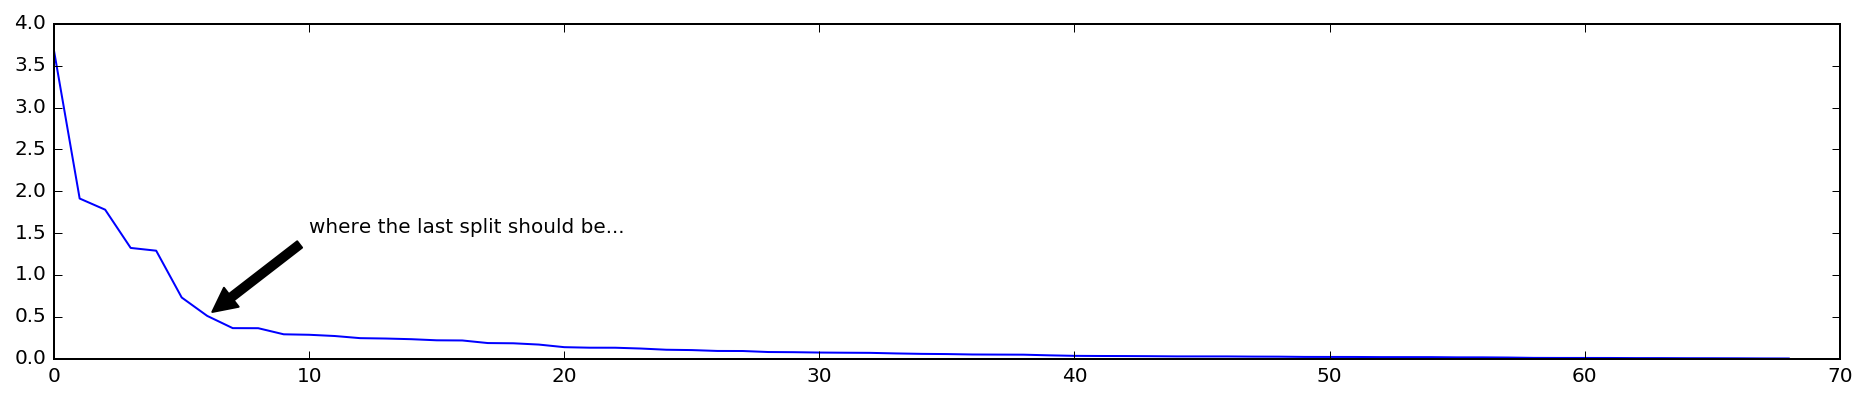

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot(np.sort(differences)[::-1])
ax.annotate('where the last split should be...', xy=(6, np.sort(differences)[::-1][6]), xytext=(10, 1.5),
            arrowprops=dict(facecolor='black', shrink=0.05))


Ну пока непонятно. Ещё картинок! Два кластера!

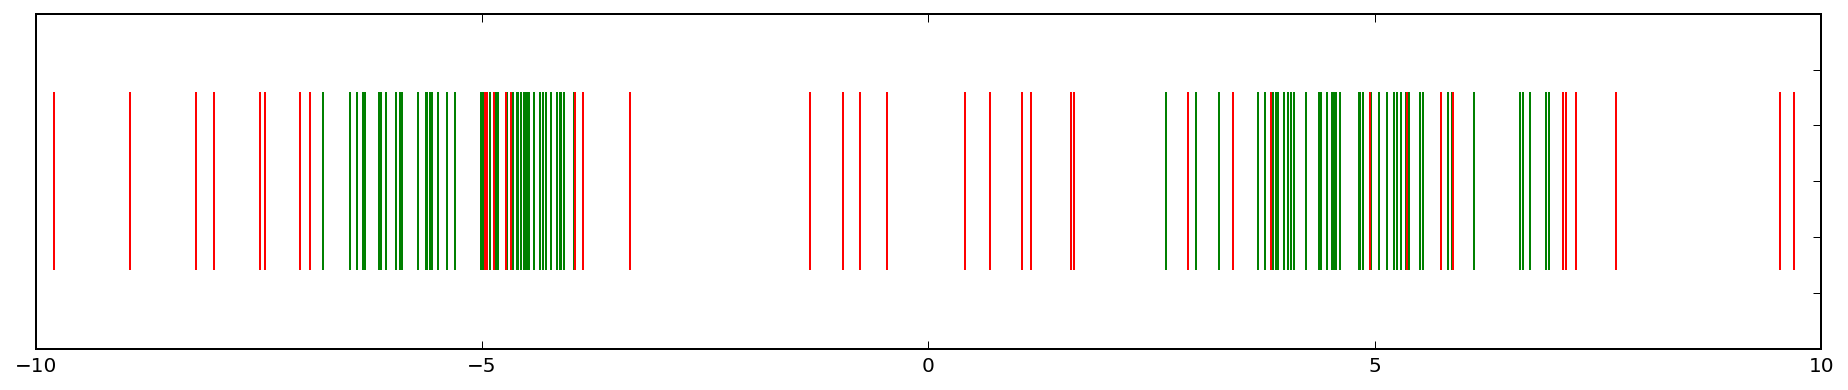

In [14]:
normal = np.append(rg.randn(50) + 5, rg.randn(50) - 5)
anomaly = rg.uniform(-10, 10, 40)
show(normal, anomaly)

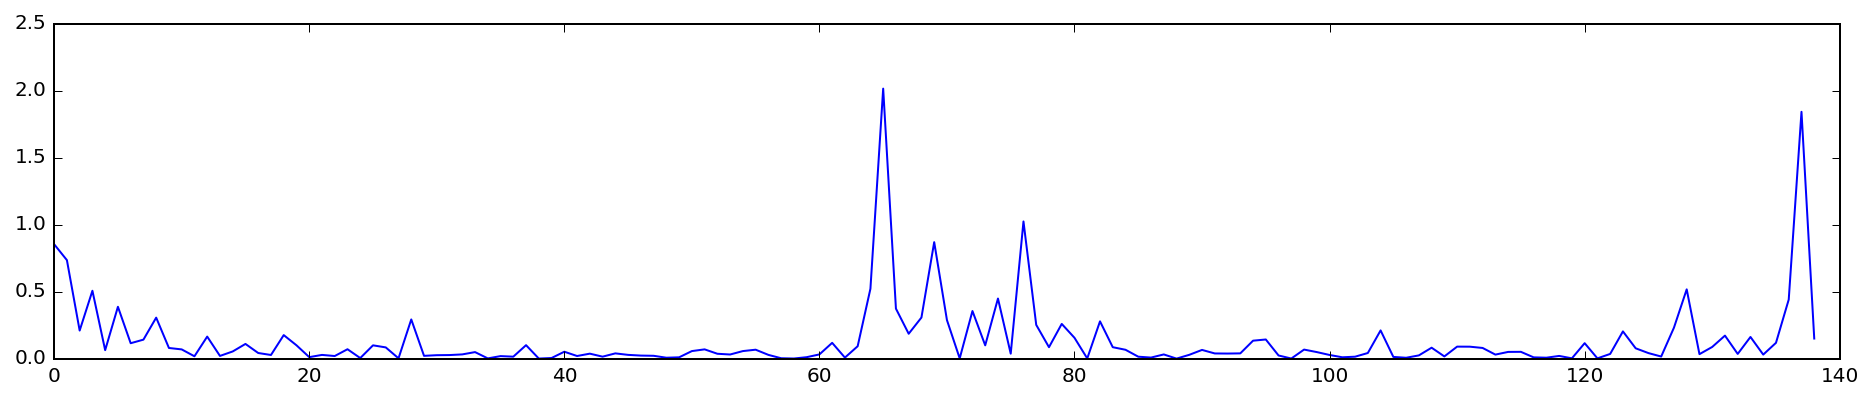

In [15]:
all_points = np.sort(np.append(normal, anomaly))
differences = all_points[1:] - all_points[:-1]
plt.plot(differences)

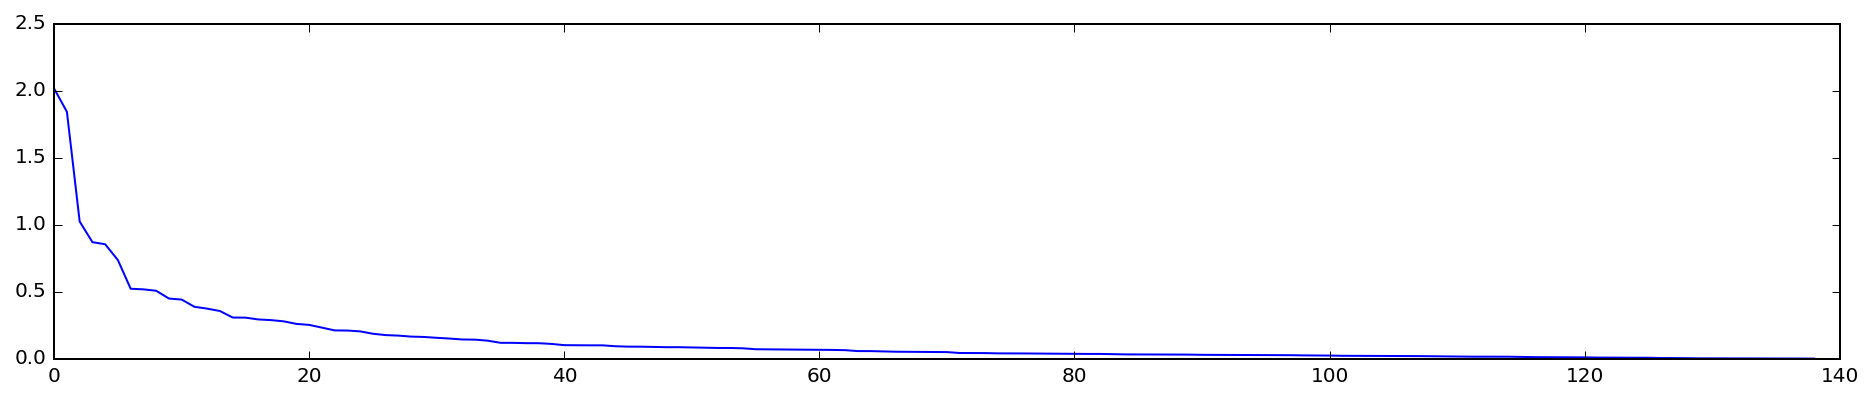

In [16]:
plt.plot(np.sort(differences)[::-1])

Вот совсем неочевидно, где должен быть последний сплит... сыграю в угадайку: вот там есть такое плато в районе y=0.5, ставлю, что самая левая точка - первый неправильный сплит...

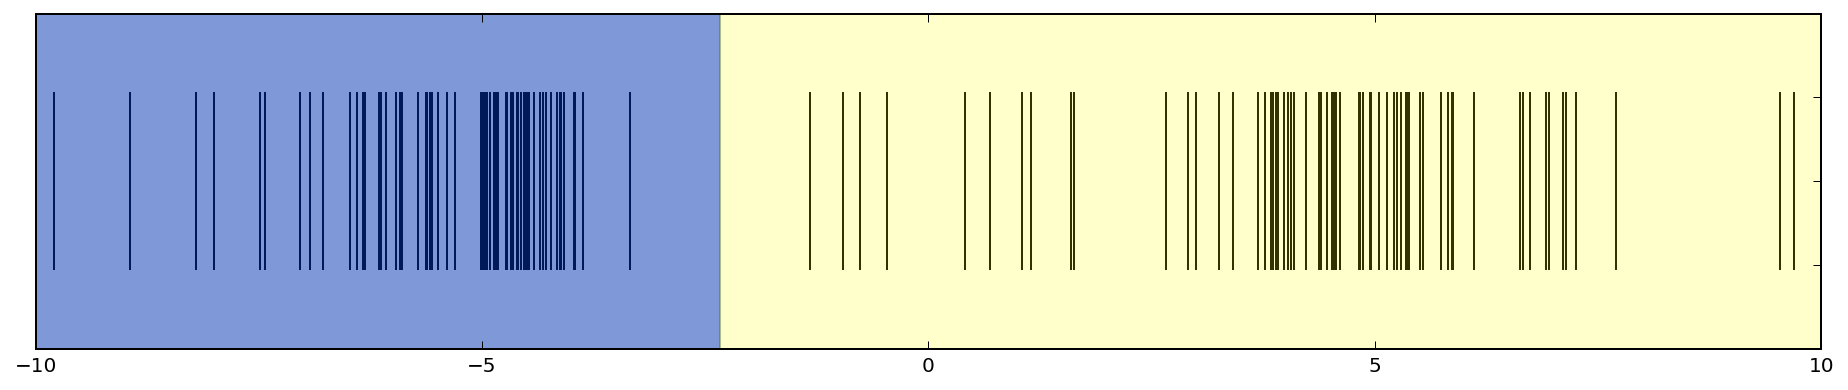

In [17]:
thresholds = (all_points[:-1] + differences / 2)[np.argsort(differences)[::-1][:1]]
draw(all_points, thresholds)

Напомню, что у нас есть три соображения, и слежка за графиком "разниц" - третье из них.

А первое - это то, что бывают сплиты, при которых "отделяется много объектов". Это можно даже уточнить. Допустим, у нас есть шесть орехов - это много или мало? Вот если чисел сто штук, то сколько из них заведомо не образует "кластер"? Или так - сколько в принципе кластеров нормалий может быть в ста числах? Вот при отсутствии нормалей десять уже вполне могут, например. То есть если на первом этапе (как в первом эксперименте) отделилось два-три объекта с краю, то тут можно особо не думать, это аномалии. А вот тут - с одной стороны больше десяти процентов, с другой - очевидно, произошло разделение на кластеры. Тут ещё стоит отметить, что если данные изначально никак не размечены, и есть кластер небольшого размера, то точно сказать, является ли он кластером аномалий или нормалий нельзя. В таком случае нужна будет какая-то сторонняя информация.

Второе же соображение говорит нам, что если этот сплит корректен и, допустим, является последним, то правые объекты - нормалии, а левые - аномалии. В таком случае, мы получим, что аномалий где-то 40%. И, вообще говоря, эти две цифры нам ничего не говорят. Иными словами, только на этом соображении успеха не достигнуть.

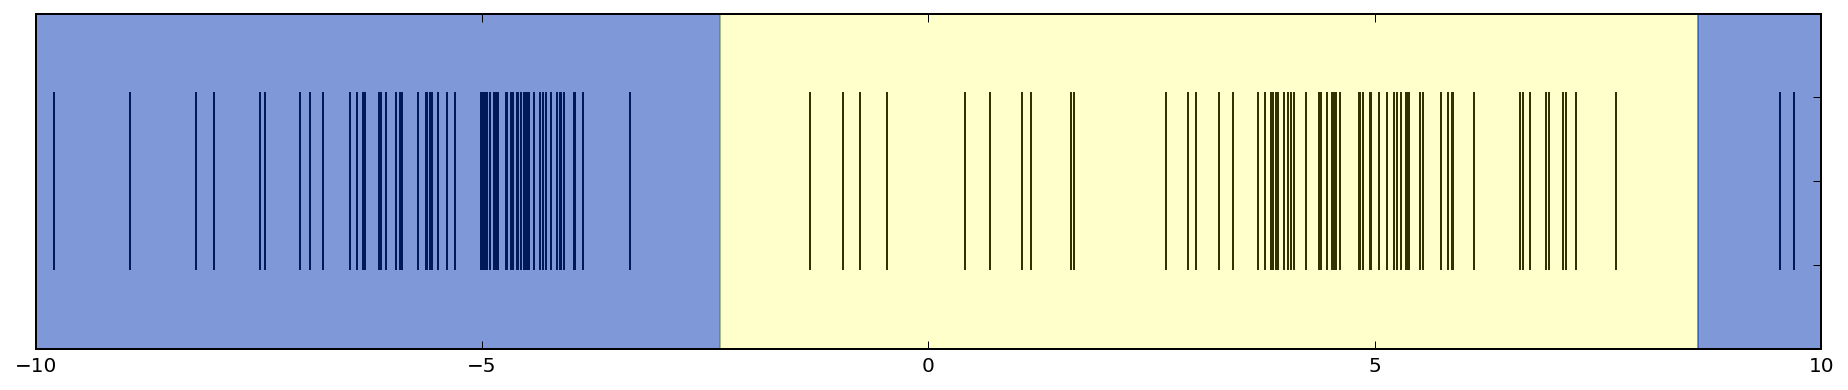

In [18]:
thresholds = (all_points[:-1] + differences / 2)[np.argsort(differences)[::-1][:2]]
draw(all_points, thresholds)

Сначала я хотел написать тут "ну вот, ничего интересного, очевидно, что аномалии отделились!", как вдруг подумал: ну раз на этом шаге отделились аномалии, значит, на предыдущих шагах сплиты были корректны. Это означает, что исходя из первого соображения, можно доказать эвристическую необходимость делать эти два сплита.

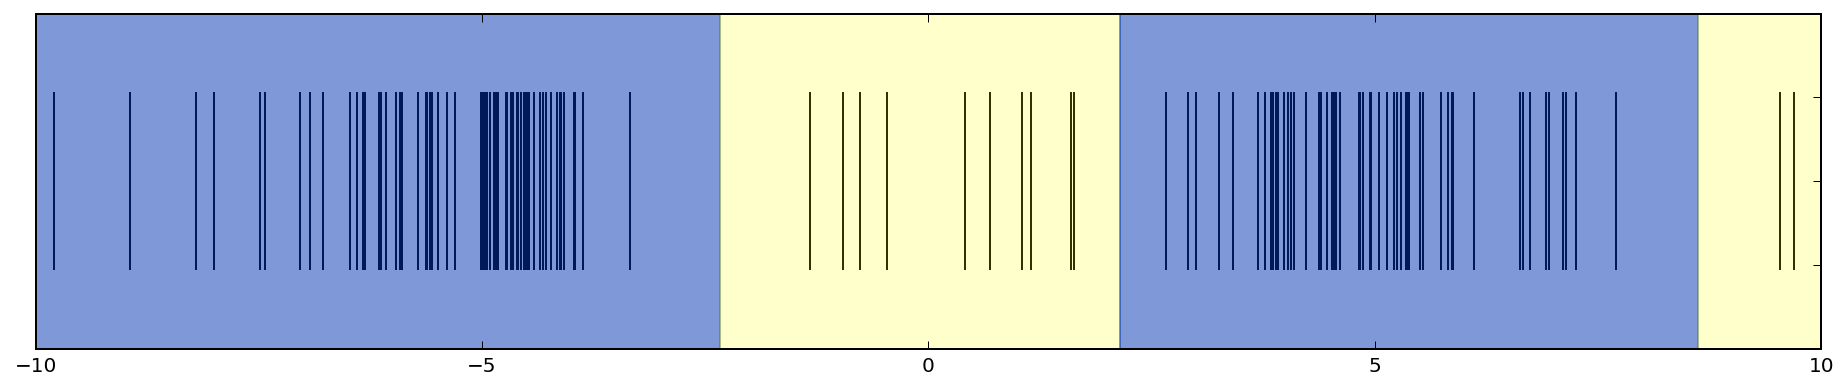

In [19]:
thresholds = (all_points[:-1] + differences / 2)[np.argsort(differences)[::-1][:3]]
draw(all_points, thresholds)

Хм. Допустим, есть некоторый порог $T$ - априорное количество чисел, которые не могут образовывать кластер. На каждом шаге можно определить, отделились ли аномалии или произошло одно из двух: а) лишний сплит б) разделились кластеры. Например, можно совершенно справедливо и всегда положить $T = 1$. 

[где-то здесь появляется ощущение того, что я изобретаю велосипед... а ведь хотел просто поспорить с предложением книги взять, предположить нормальное распределение исходных данных и засчитать аномалиями всё, что не вписывается в правило трёх сигм...]

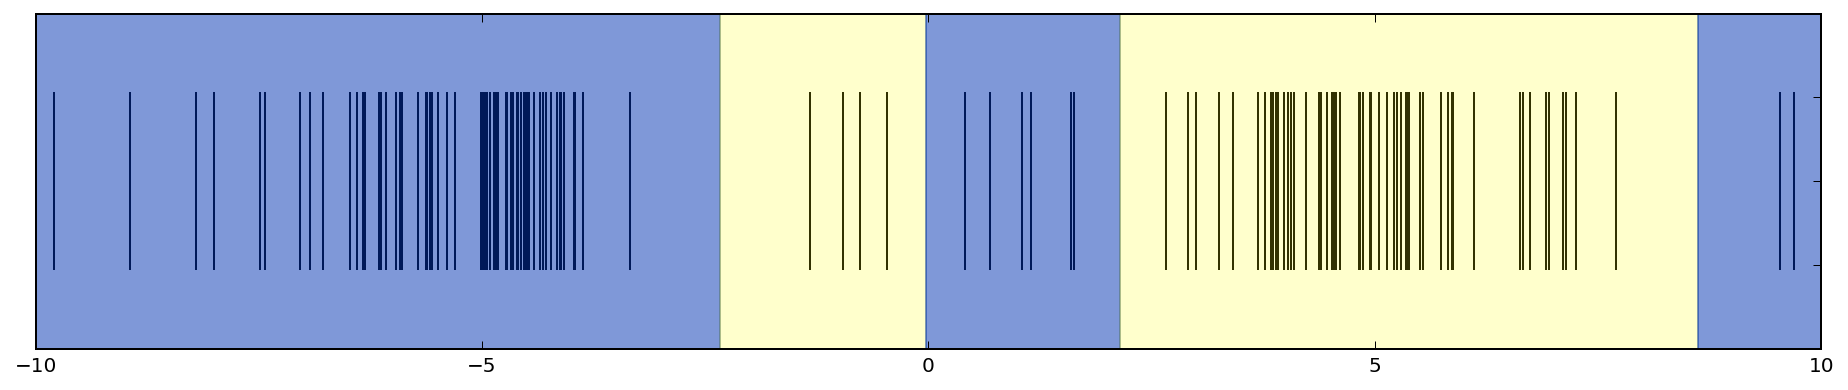

In [20]:
thresholds = (all_points[:-1] + differences / 2)[np.argsort(differences)[::-1][:4]]
draw(all_points, thresholds)

Вот если бы было $T >= 4$, то можно было бы снова доказывать корректность таких разделений...

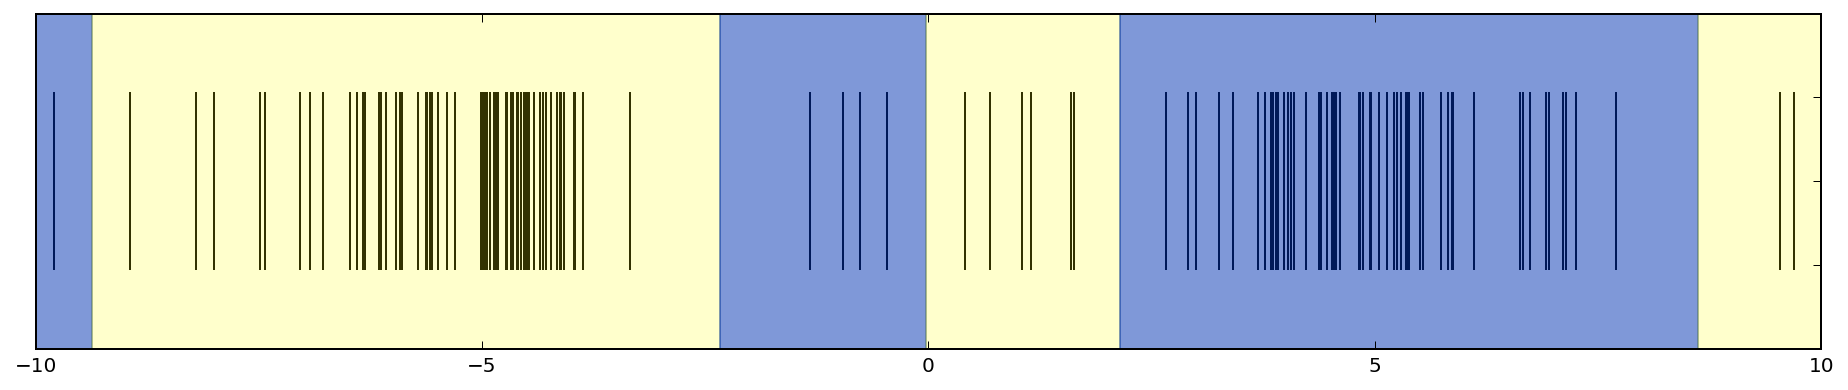

In [21]:
thresholds = (all_points[:-1] + differences / 2)[np.argsort(differences)[::-1][:5]]
draw(all_points, thresholds)

Хотя не, $T=1$ пока хватает... ;)

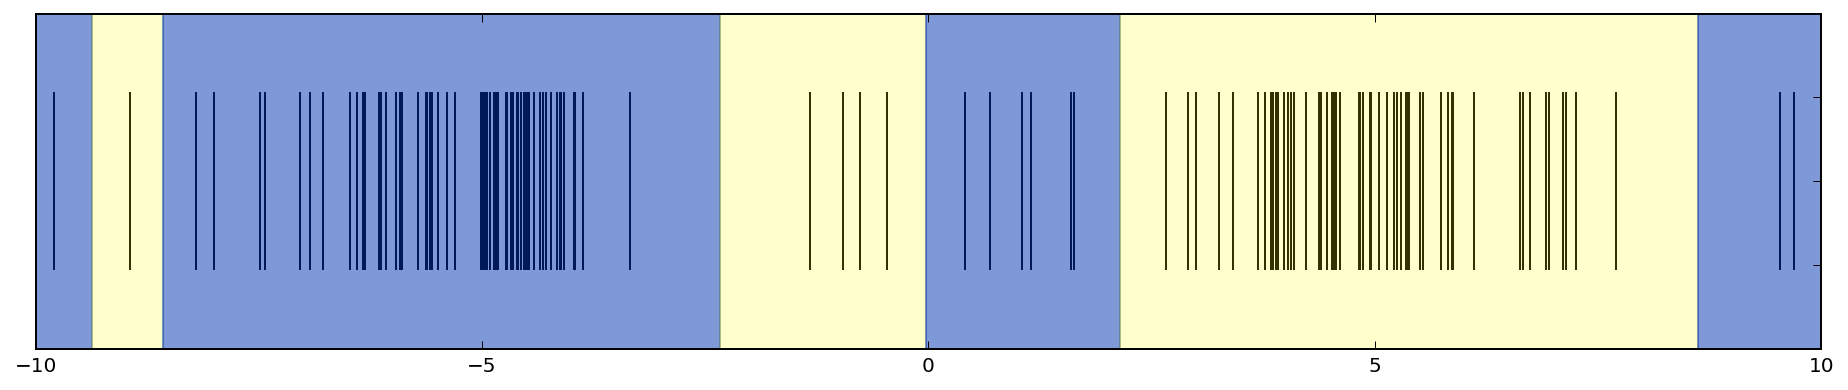

In [22]:
thresholds = (all_points[:-1] + differences / 2)[np.argsort(differences)[::-1][:6]]
draw(all_points, thresholds)

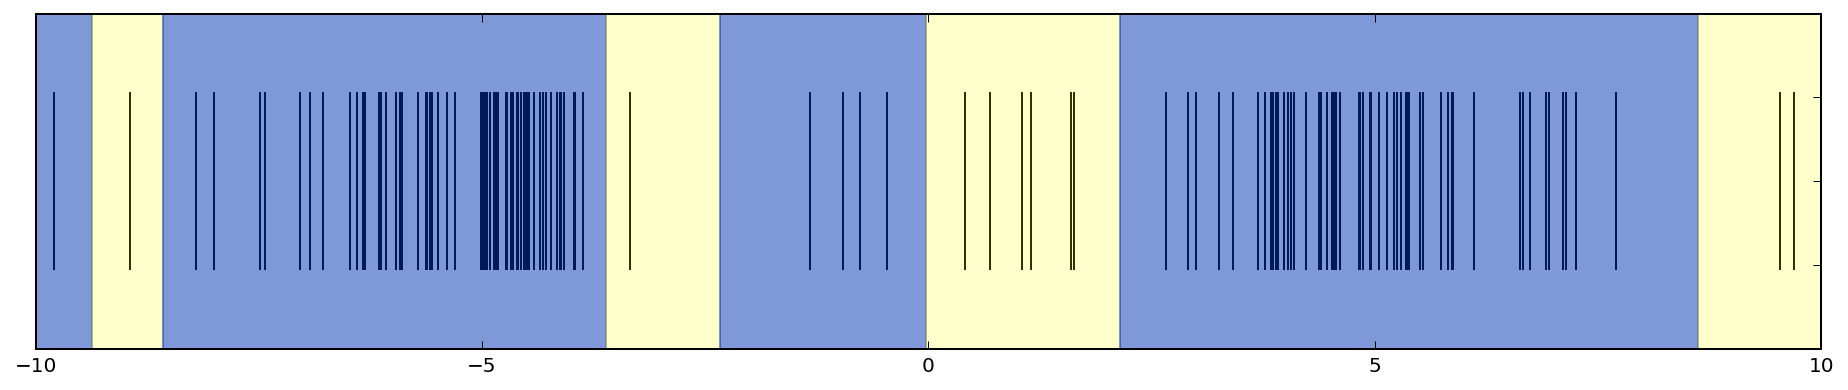

In [23]:
thresholds = (all_points[:-1] + differences / 2)[np.argsort(differences)[::-1][:7]]
draw(all_points, thresholds)

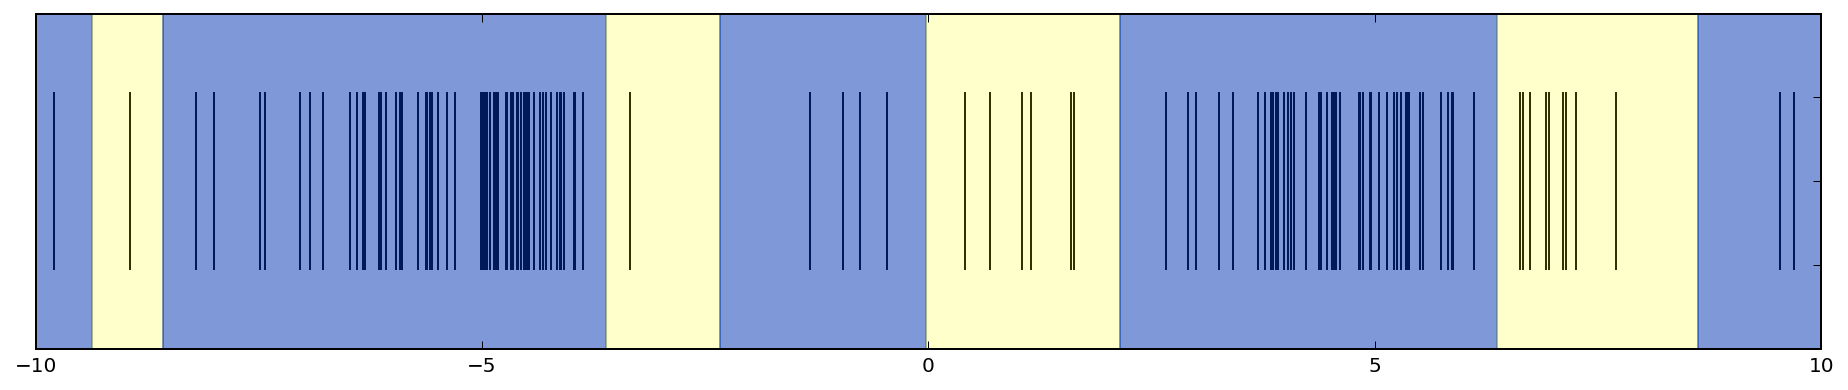

In [24]:
thresholds = (all_points[:-1] + differences / 2)[np.argsort(differences)[::-1][:8]]
draw(all_points, thresholds)

Хотя что значит "доказать корректность предыдущих разбиений"?
Так можно сделать сплитов по количеству объектов, заявить, что на последнем сплите отделился один объект, и заявить, что все разделения корректны...

А вот согласно второму рассуждению, попытки на текущем разбиении раздать метки приведёт к следующим действиям: 1) выдать вердикт "нормалии" левому большому синему кластеру. 2а) объявить остальное аномалиями (аномалий получится в процентном соотношении много) 2б) выдать вердикт "нормалии" правому большому синему кластеру => выдать вердикт "аномалии" соседним с ним двум таким для аномалий приличным кластерам.

Конечно, хоть какая-то априорная оценка того, сколько в данных аномалий должна быть. Например, "ну аномалий явно меньше нормальных данных". Пусть это очень обширный порог, может, от 5% до 50%. Но это тоже какая-никакая информация.

Исходя из того, что потерять аномалию хуже, истинным решением в данной ситуации является засчитать этот сплит корректным. Ну хорошо, для любопытства пока поинтересуюсь, какой скор (метрика - взвешанная f-мера) был бы при таком разбиении (и оптимальном выставлении меток согласно рассуждениям выше)

In [25]:
def score(f, y, verbose=True):
    right_shots = np.logical_and(f == 1, f == y).sum()
    precision = right_shots / (f == 1).sum()
    recall = right_shots / (y == 1).sum()
    if verbose:
        print("precision = ", precision)
        print("recall = ", recall)
        print("f-measure = ", precision * recall / (0.5 * precision + 0.5 * recall))
    return precision * recall / (0.5 * precision + 0.5 * recall)

thresholds = (all_points[:-1] + differences / 2)[np.argsort(differences)[::-1][:8]]

all_data = np.append(normal, anomaly)
n_of_cluster = np.array([all_data > threshold for threshold in thresholds]).sum(axis=0)

f = np.logical_and(n_of_cluster != 2, n_of_cluster != 6)
y = np.append(np.zeros_like(normal), np.ones_like(anomaly))
score(f, y)

precision =  0.8
recall =  0.5
f-measure =  0.615384615385


0.61538461538461542

Хмф, ну окей, едем дальше

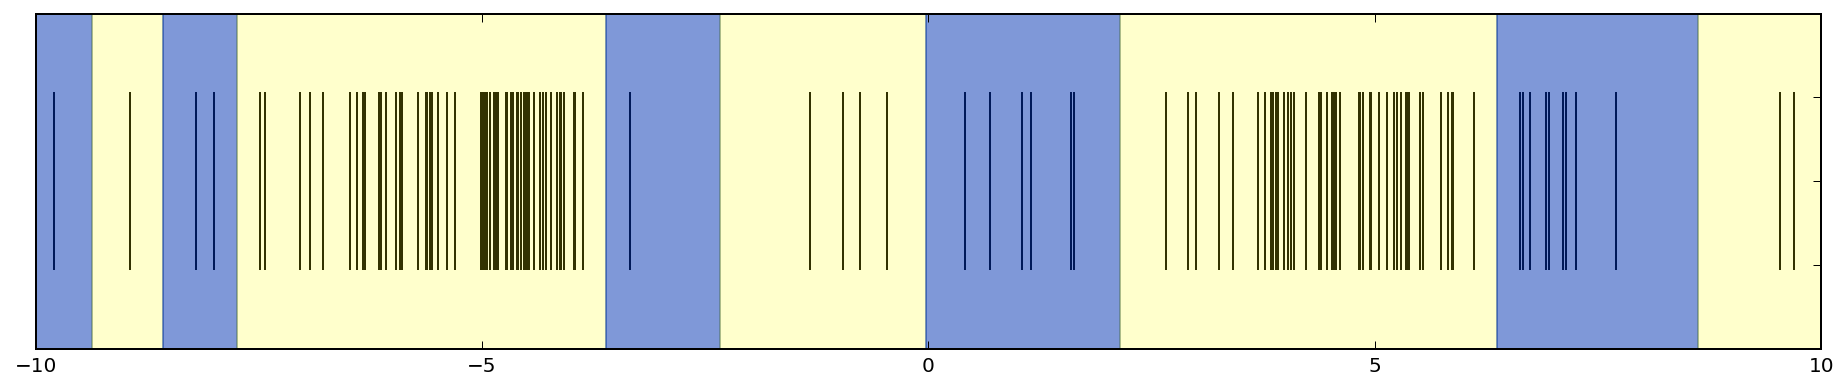

In [26]:
thresholds = (all_points[:-1] + differences / 2)[np.argsort(differences)[::-1][:9]]
draw(all_points, thresholds)

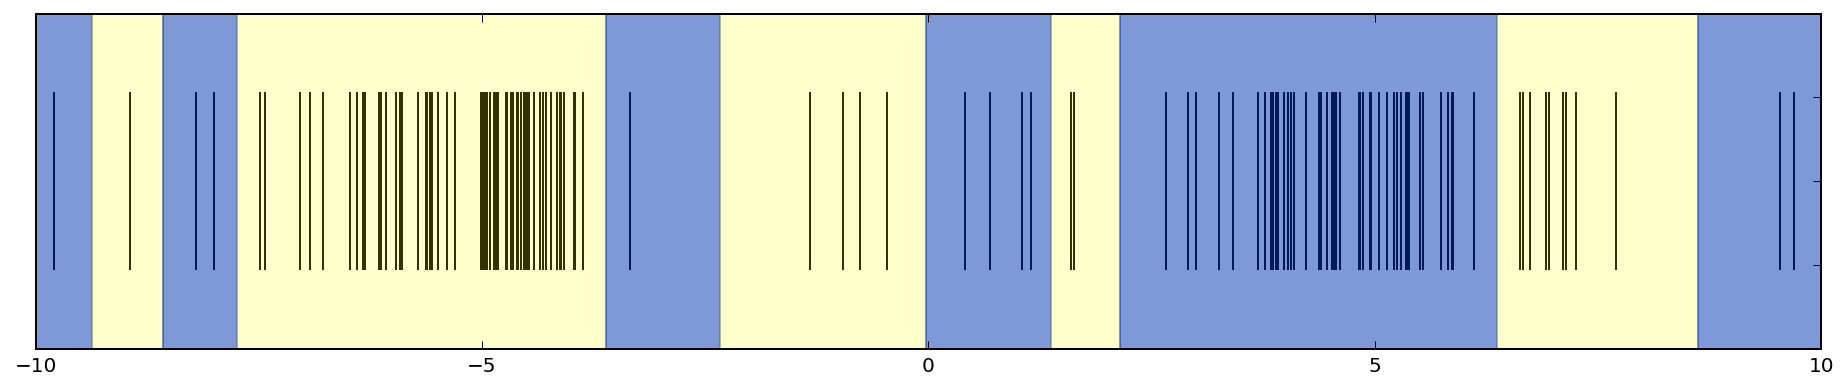

In [27]:
thresholds = (all_points[:-1] + differences / 2)[np.argsort(differences)[::-1][:10]]
draw(all_points, thresholds)

Два интересных сплита - в первом откалывается кусок от большой группы, во втором - от маленькой. Например, исходя из соображений проставления меток, можно было бы отметить, что большая группа является содержащим кластер нормалий, а маленькая скорее всего состоит из аномалий. И вот, видя, что в группе аномалий делается сплит, уже точно можно объявить корректность сделанных шагов.

Ещё одним соображением источника информации может быть следующее: дисперсия внутри каждой группы. Это тоже некоторая оценка того, насколько та или иная группа вероятно является группой из одних аномалий.

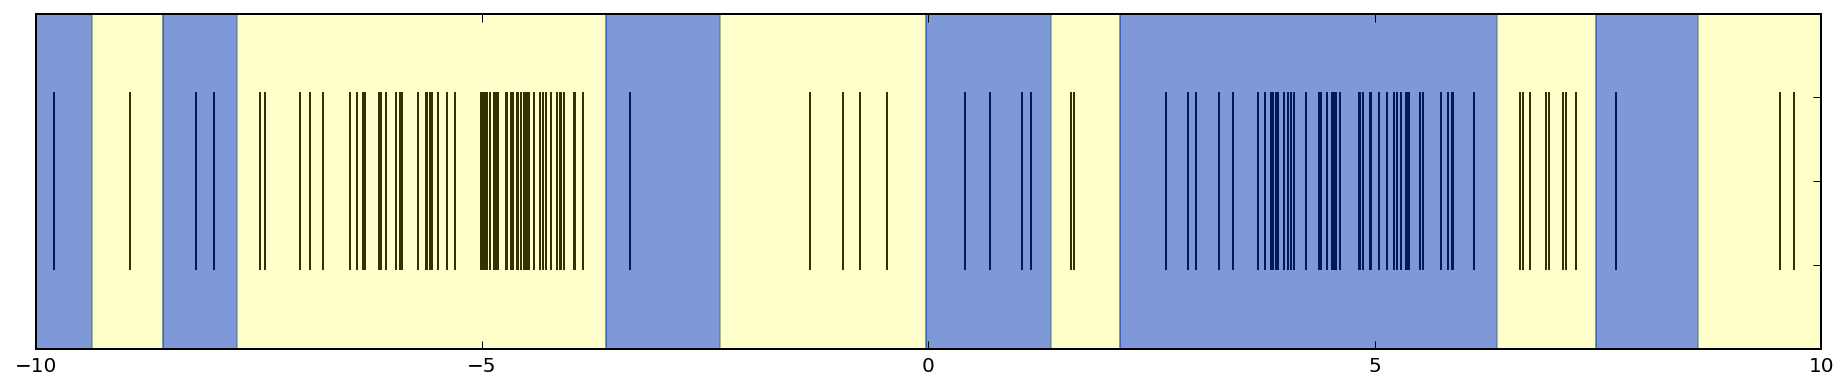

In [28]:
thresholds = (all_points[:-1] + differences / 2)[np.argsort(differences)[::-1][:11]]
draw(all_points, thresholds)

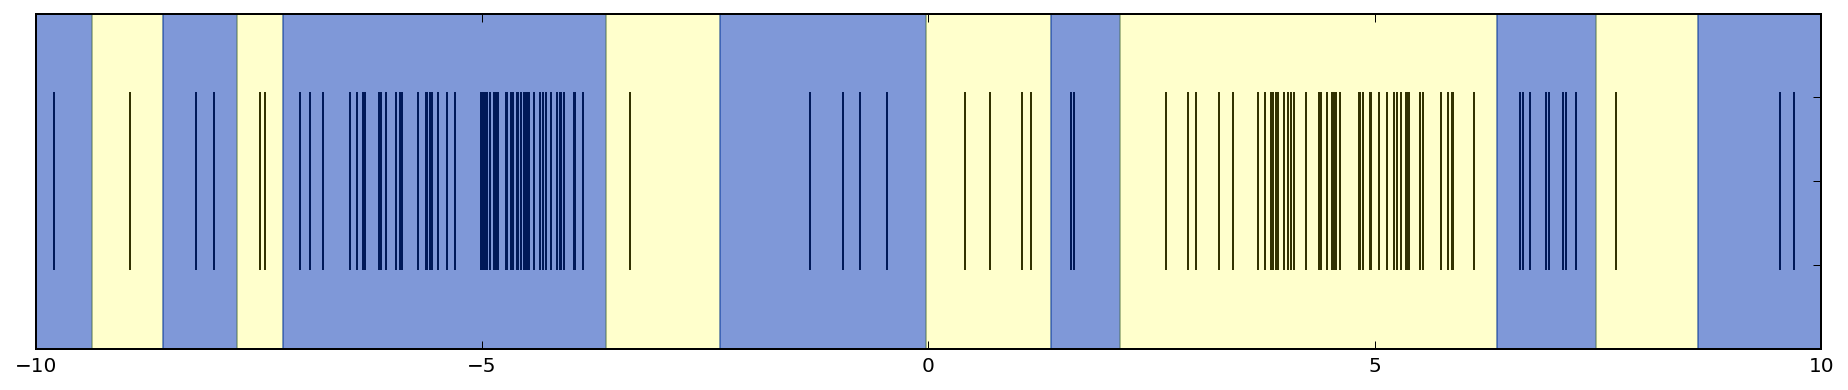

In [29]:
thresholds = (all_points[:-1] + differences / 2)[np.argsort(differences)[::-1][:12]]
draw(all_points, thresholds)

In [30]:
thresholds = (all_points[:-1] + differences / 2)[np.argsort(differences)[::-1][:12]]

all_data = np.append(normal, anomaly)
n_of_cluster = np.array([all_data > threshold for threshold in thresholds]).sum(axis=0)

f = np.logical_and(n_of_cluster != 4, n_of_cluster != 9)
y = np.append(np.zeros_like(normal), np.ones_like(anomaly))
score(f, y)

precision =  0.827586206897
recall =  0.6
f-measure =  0.695652173913


0.69565217391304346

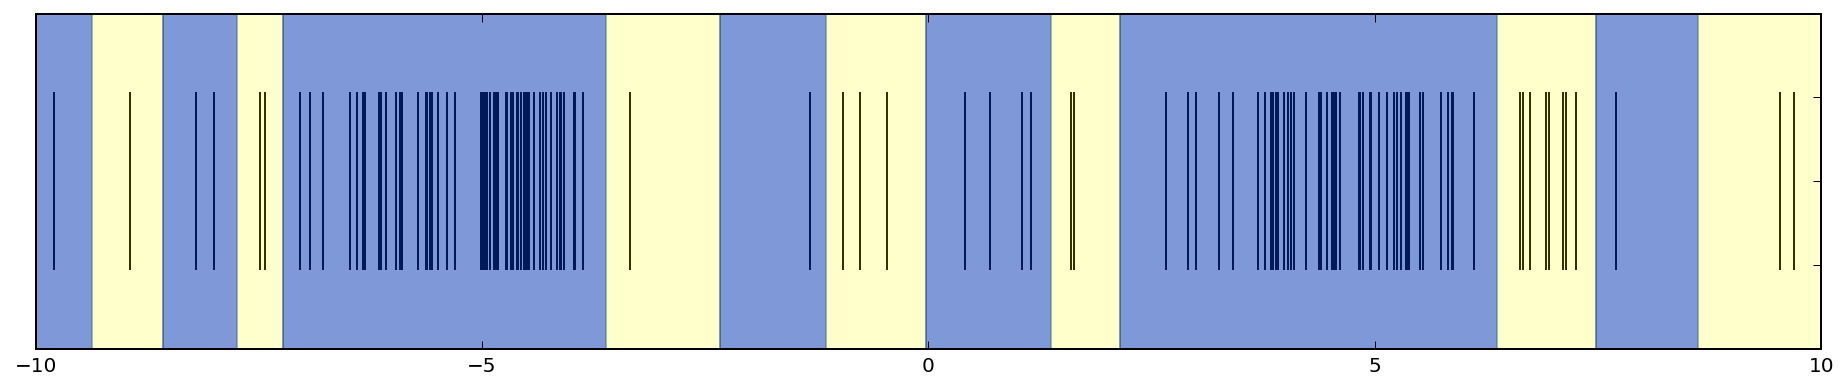

In [31]:
thresholds = (all_points[:-1] + differences / 2)[np.argsort(differences)[::-1][:13]]
draw(all_points, thresholds)

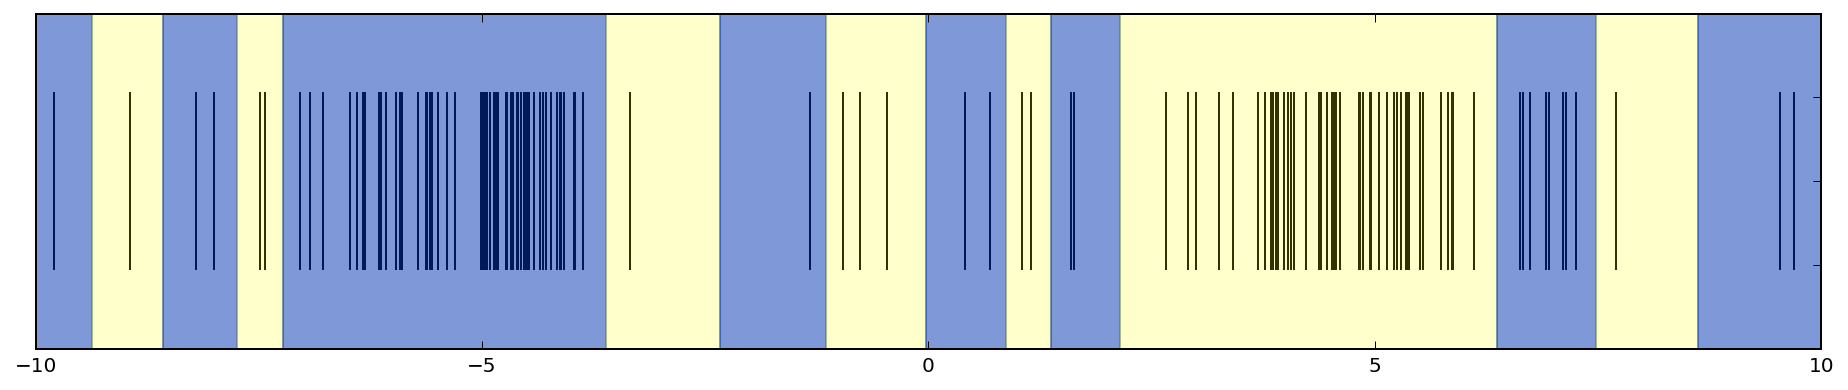

In [32]:
thresholds = (all_points[:-1] + differences / 2)[np.argsort(differences)[::-1][:14]]
draw(all_points, thresholds)

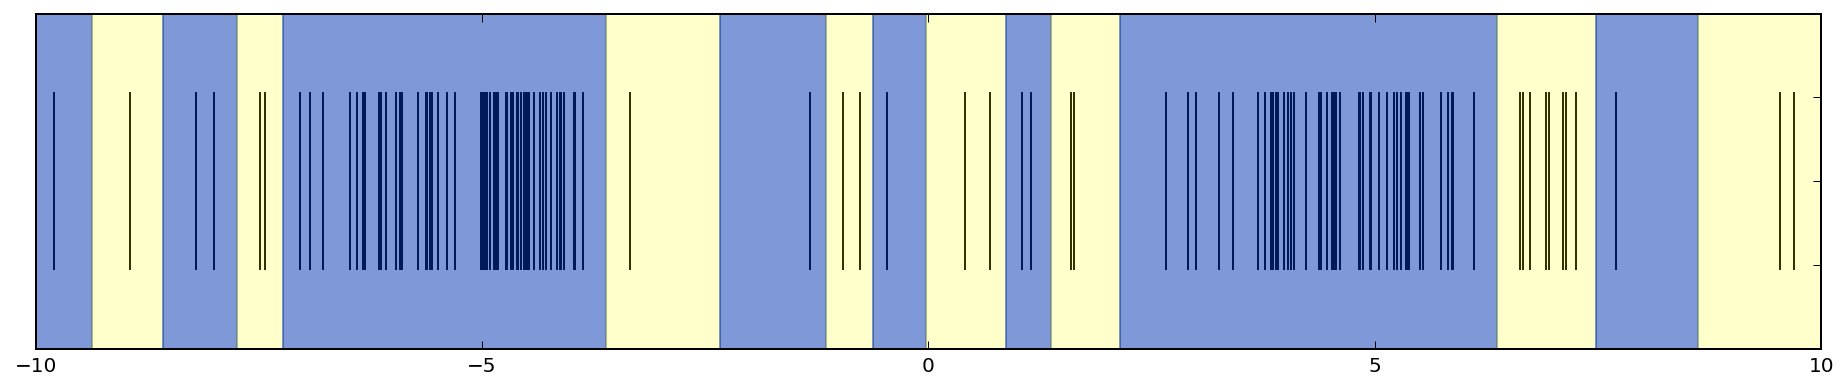

In [33]:
thresholds = (all_points[:-1] + differences / 2)[np.argsort(differences)[::-1][:15]]
draw(all_points, thresholds)

Вот если предполагать, что вот эта группа в серединке, подвергнувшаясь трижды раздроблению, исходно была аномальной, то можно довести алгоритм до этого момента.

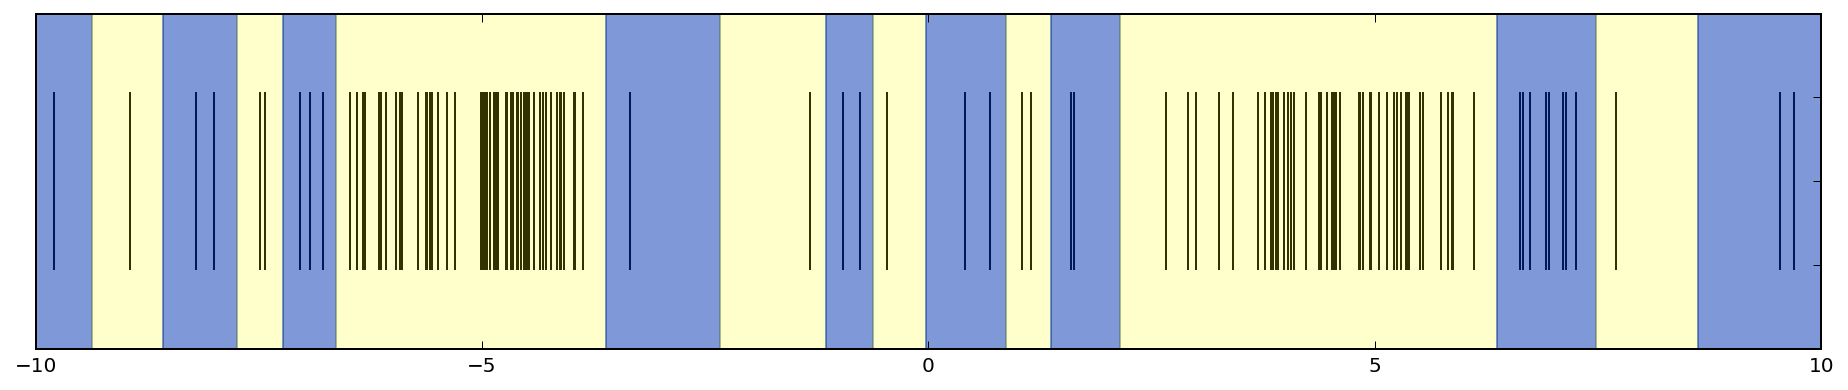

In [34]:
thresholds = (all_points[:-1] + differences / 2)[np.argsort(differences)[::-1][:16]]
draw(all_points, thresholds)

In [35]:
thresholds = (all_points[:-1] + differences / 2)[np.argsort(differences)[::-1][:16]]

all_data = np.append(normal, anomaly)
n_of_cluster = np.array([all_data > threshold for threshold in thresholds]).sum(axis=0)

f = np.logical_and(n_of_cluster != 5, n_of_cluster != 13)
y = np.append(np.zeros_like(normal), np.ones_like(anomaly))
score(f, y)

precision =  0.8125
recall =  0.65
f-measure =  0.722222222222


0.72222222222222232

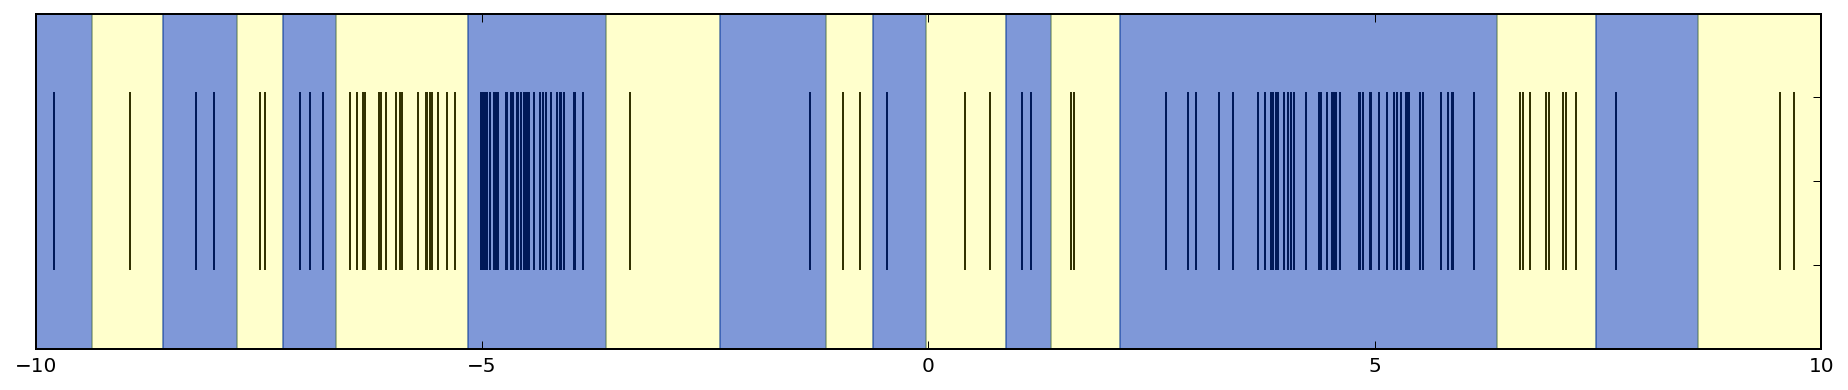

In [36]:
thresholds = (all_points[:-1] + differences / 2)[np.argsort(differences)[::-1][:17]]
draw(all_points, thresholds)

Вот, представление окончено.
Посмотрим, угадал ли я точку на графике.

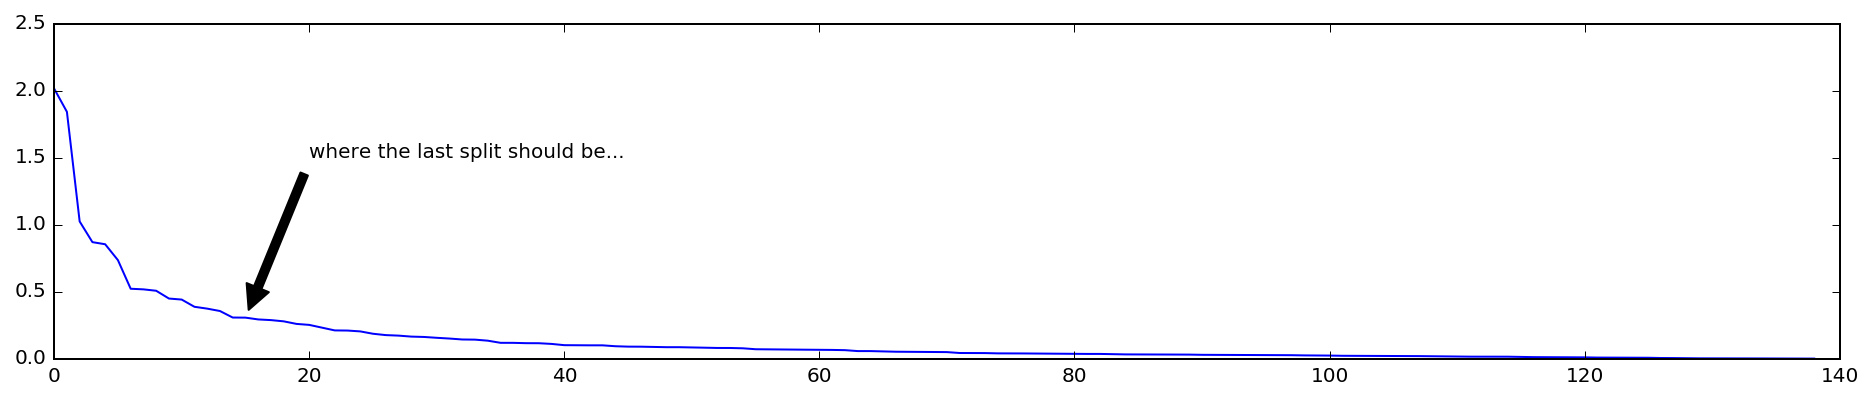

In [37]:
fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot(np.sort(differences)[::-1])
ax.annotate('where the last split should be...', xy=(15, np.sort(differences)[::-1][15]), xytext=(20, 1.5),
            arrowprops=dict(facecolor='black', shrink=0.05))

Не-а, чёт совсем не угадал...
А значит, только исследования графика "разностей" для алгоритмического интеллектуально верного решения не хватает.

Подведём некоторый итог. Допустим, мы отделим понятия "хорошего сплита" (отделяющего, скажем, не более $T=4$ объектов), который точно наверняка отделяет именно аномалии и потому он хороший, и понятие плохого сплита, который вводит в неопределённость. В последнем примере такими сплитами являются 1-ый, 3-й, 8-й и 17-ый. Среди плохих сплитов нужно искать остановку (это уже некоторый результат). При этом это для данного $T$. Может быть, можно как-то их поперебирать и оценить результат, может быть, можно смотреть за графиком разностей или выуживать информацию из алгоритма проставления меток (который тоже неоднозначен...). Хм. Минуточку. Что, если алгоритм проставления меток будет учитывать ограничение $T$?

Мол, допустим, аномалии не образуют кластеры размером больше $T$. При очередном сплите, пытаясь проставить метки, можно учитывать, что если аномалией названа группа, состоящая более чем из $T$ чисел, то останавливаться на этом разбиении нельзя. Такие ограничения могут оказаться очень жёсткими, и для большинства $T$ скорее всего решений вообще не будет! Можно начать перебор от $T=1$, для которых решений заведомо нет, и увеличивать его, пока решение не будет найдено.

При этом $T$, для которого решение будет, существует - в случае первого сплита.

Во сне ко мне прилетела фея и заметила, что процесс разбиения от $T$ не зависит, а зависит только принятие решения, на каком сплите останавливаться. Это означает, что алгоритм сводится к следующему: делаем сплиты достаточно большое число шагов, на каждом этапе вычисляем, из скольких аномалий состоит самый большой "кластер" аномалий и сколько всего аномалий "получается" в датасете - применением алгоритма расставления меток.

Алгоритм расставления меток. Группой нормалий объявляется самая большая группа, затем - вторая по размеру, и так далее; если сплиты сделаны в достаточном количестве, то аномалии не образуют кластера размером больше $T$. Как вариант: можно при расставлении меток минимизировать $T$. С одной стороны, все кластера будут отнесены к разряду нормалий. С другой стороны, если ограничения на $T$ неизвестны, и истинное значение маленьких кластеров остаётся неизвестным. 

In [38]:
# получаем номера кластеров, которые для данных разбиение объявляются нормалиями
def get_normals_clusters(n_of_cluster, thresholds):
    normals_clusters = set()
    for i in np.argsort(np.bincount(n_of_cluster))[::-1]:
        if i - 1 in normals_clusters or i + 1 in normals_clusters:
            break
        normals_clusters.add(i)
    return normals_clusters

# получаем значение T - то есть какой самый большой кластер образуют аномалии 
# (при таких сплитах и таком алгоритме отбора нормалий)
def T(n_of_cluster, thresholds):
    normals_clusters = get_normals_clusters(n_of_cluster, thresholds)
    return np.sort(np.bincount(n_of_cluster))[::-1][len(normals_clusters)]

# прогнозирование
def f(n_of_cluster, thresholds):
    normals_clusters = get_normals_clusters(n_of_cluster, thresholds)
    return np.array([not n in normals_clusters for n in n_of_cluster])

def draw_thr(n_of_cluster, all_points, thresholds, xlim=10):
    normals_clusters = get_normals_clusters(n_of_cluster, thresholds)
    thresholds = np.append(thresholds, all_points.max() + 1)
    currentAxis = plt.gca()
    start = all_points.min() - 1
    colors = [(0.7, 0, 0.2, 0.5), (1, 0, 0, 0.5)]
    normal_color = (0, 1, 0, 0.5)
    
    for i in np.arange(len(thresholds)):
        new_one = np.sort(thresholds)[i]
        currentColor = colors[i%2]
        if i in normals_clusters: currentColor = normal_color
        currentAxis.add_patch(plt.Rectangle((start, -1), new_one - start, 2, color=currentColor))
        start = new_one
    
    plt.scatter(all_points, np.zeros_like(all_points), marker='|', c='black', s=8000)
    plt.tick_params(axis='y', left='off', labelleft='off')
    plt.ylim(-1, 1)
    plt.xlim(-xlim, xlim)
    plt.show()

1  SPLITS:
T =  66
Anomalies Fraction =  0.471428571429 %


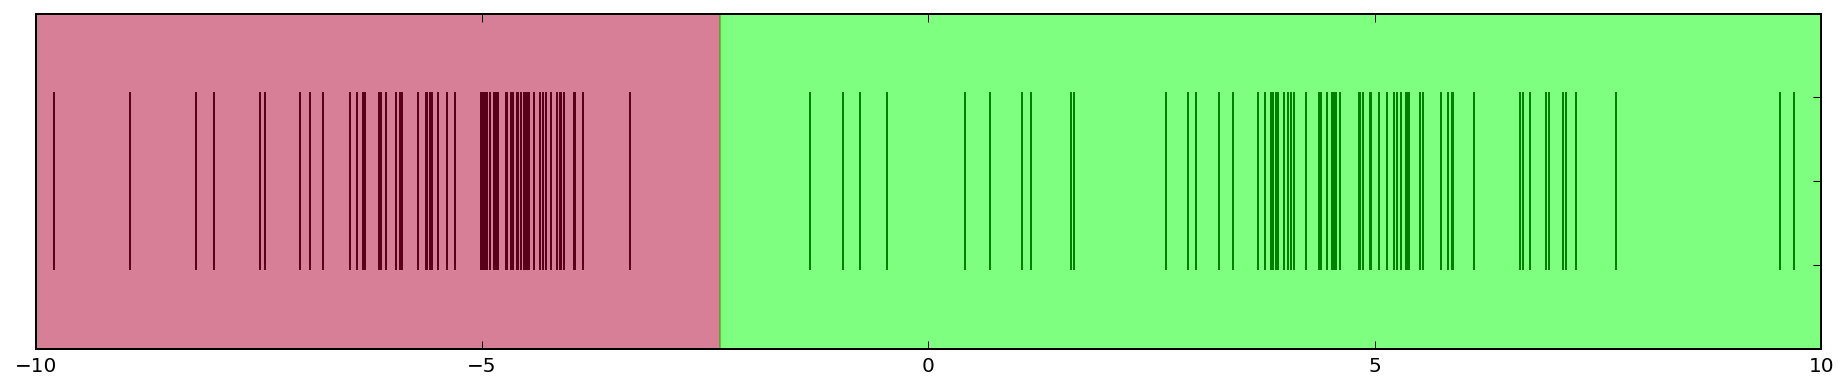

2  SPLITS:
T =  66
Anomalies Fraction =  0.485714285714 %


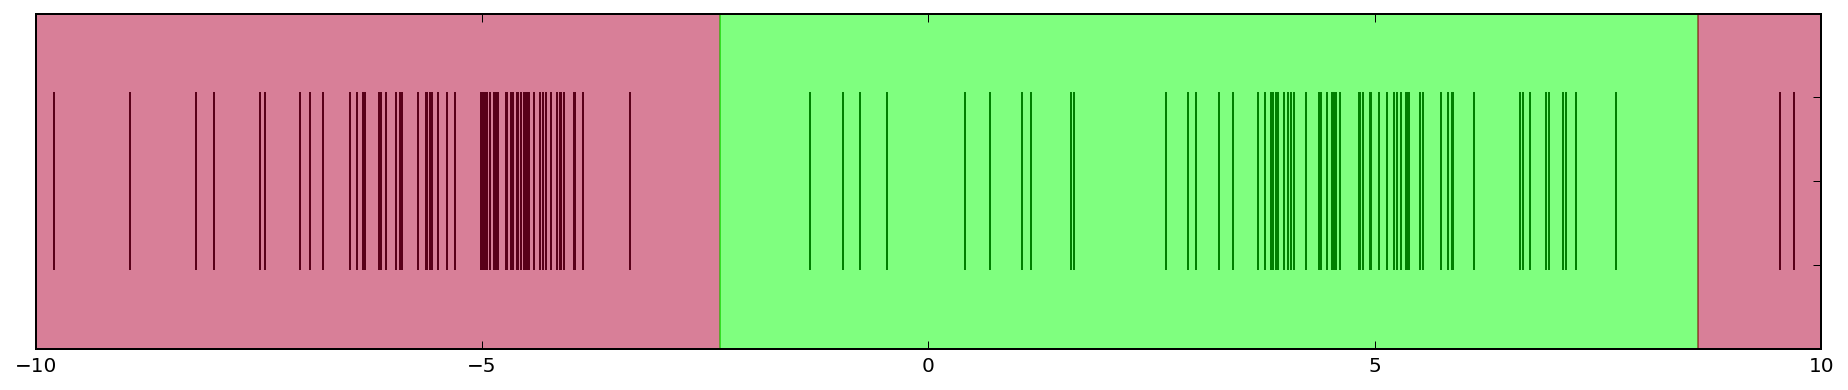

3  SPLITS:
T =  11
Anomalies Fraction =  0.0928571428571 %


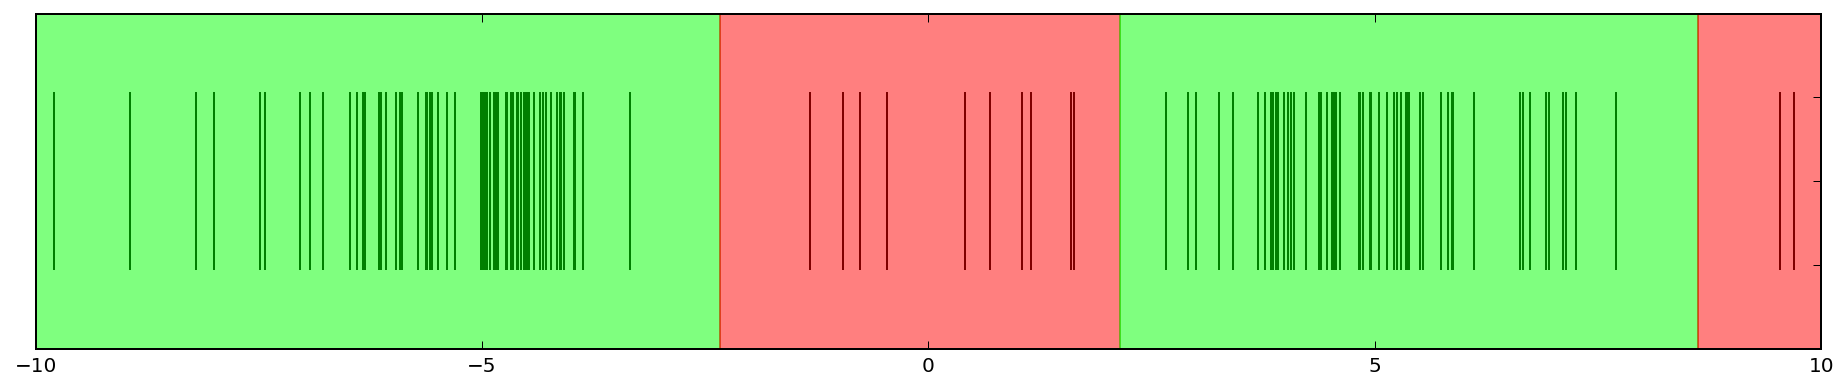

4  SPLITS:
T =  7
Anomalies Fraction =  0.0928571428571 %


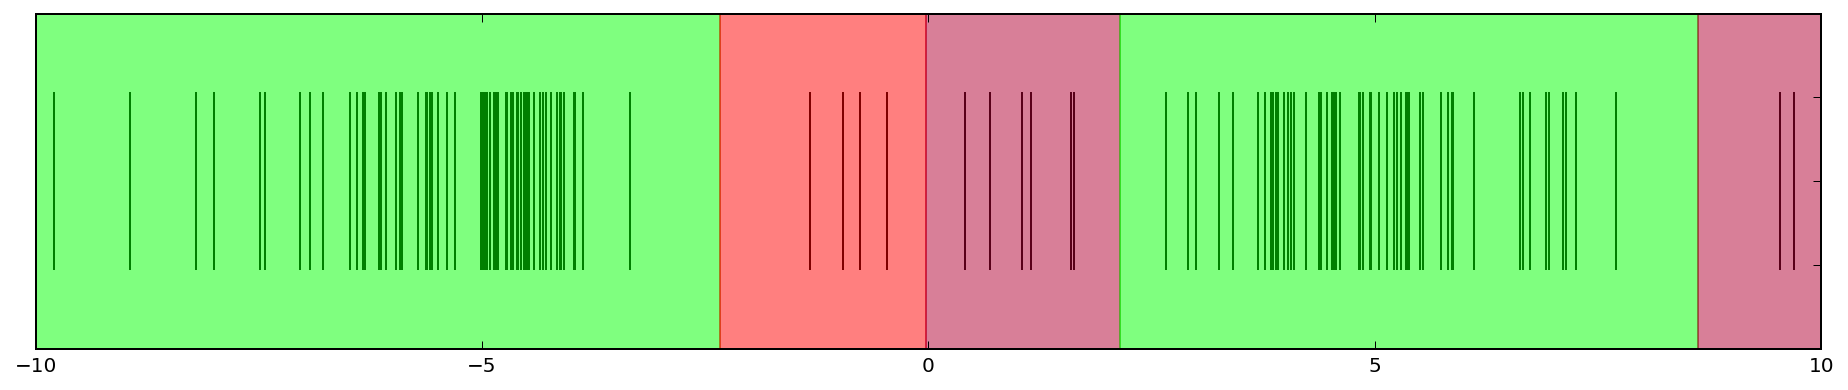

5  SPLITS:
T =  7
Anomalies Fraction =  0.1 %


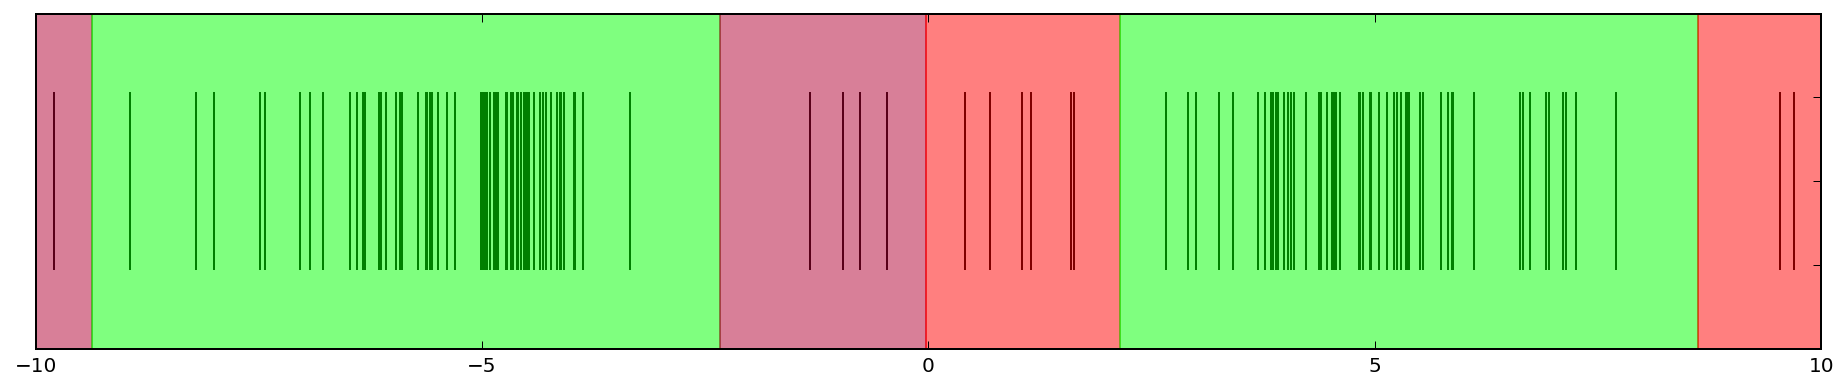

6  SPLITS:
T =  7
Anomalies Fraction =  0.107142857143 %


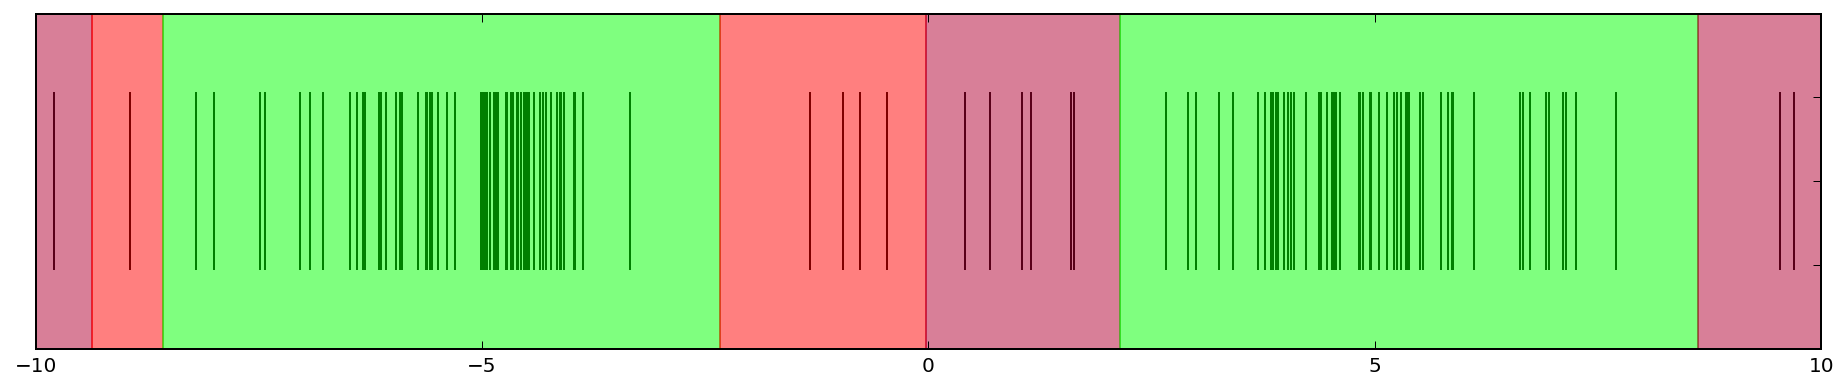

7  SPLITS:
T =  7
Anomalies Fraction =  0.114285714286 %


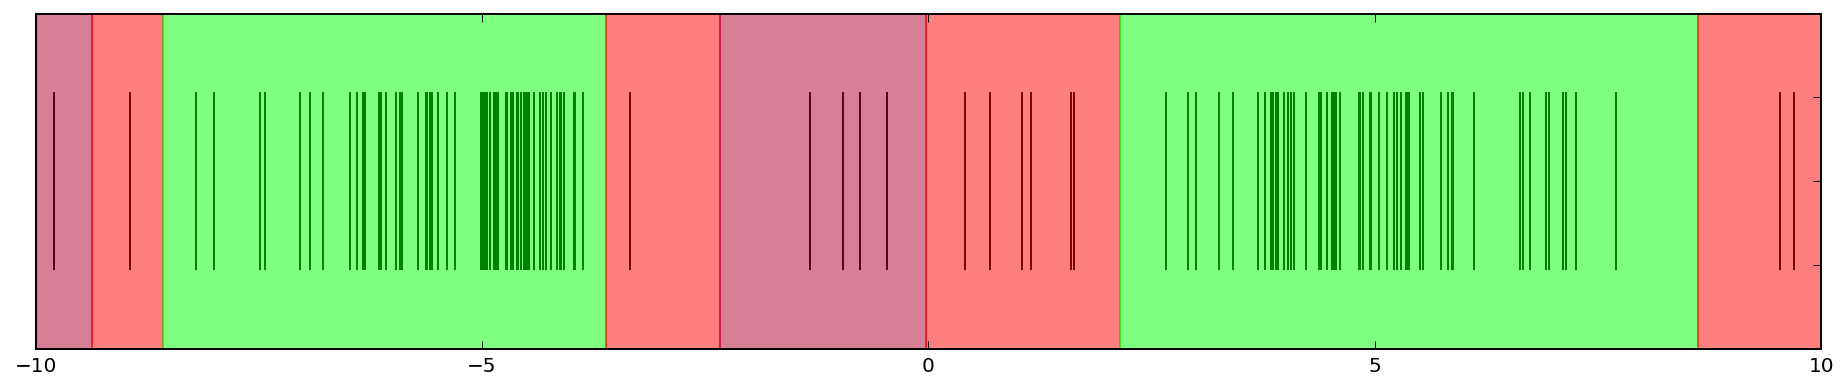

8  SPLITS:
T =  9
Anomalies Fraction =  0.178571428571 %


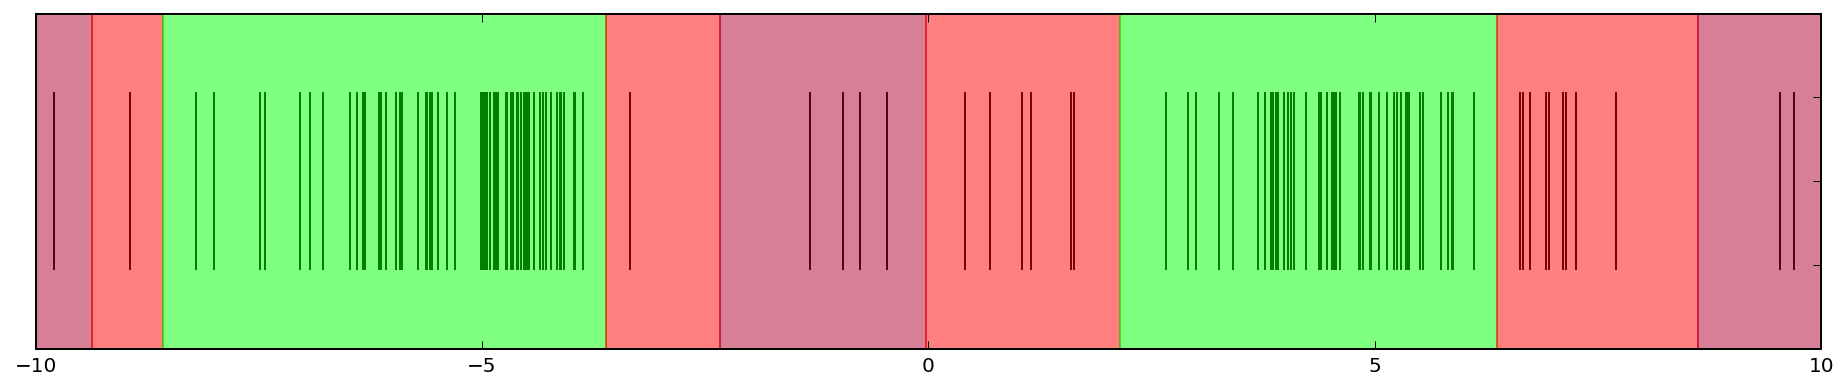

9  SPLITS:
T =  9
Anomalies Fraction =  0.192857142857 %


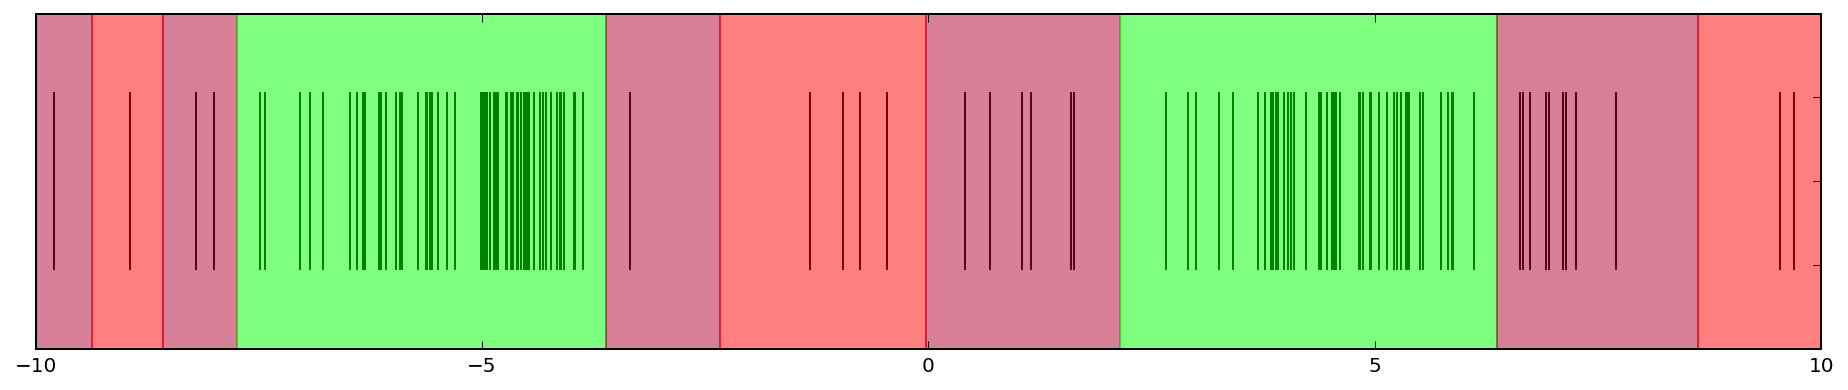

10  SPLITS:
T =  9
Anomalies Fraction =  0.192857142857 %


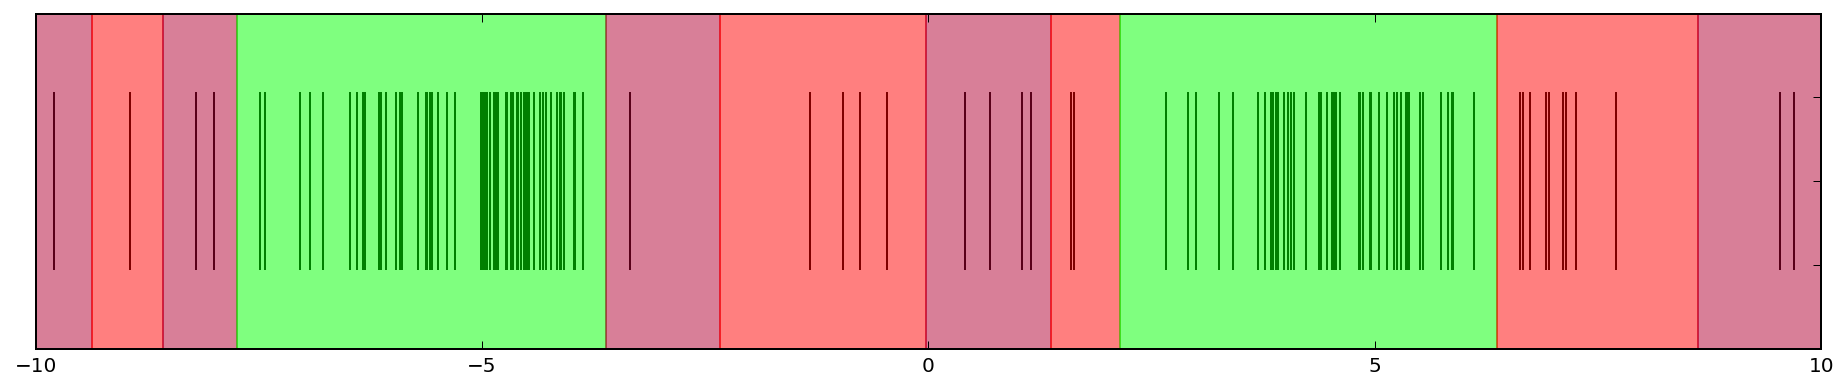

11  SPLITS:
T =  8
Anomalies Fraction =  0.192857142857 %


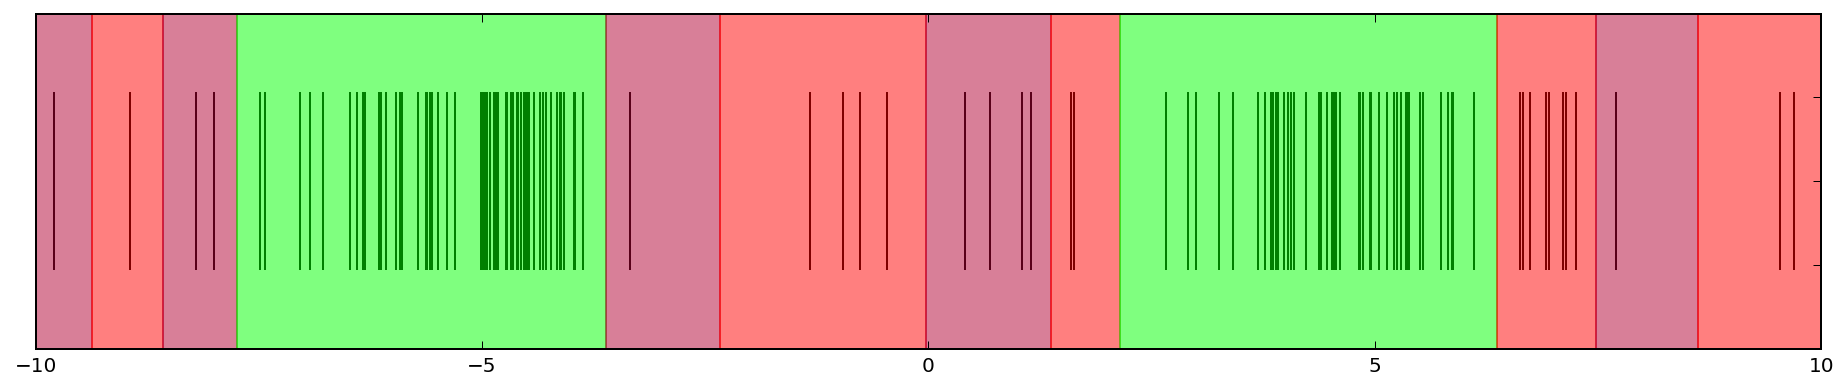

12  SPLITS:
T =  8
Anomalies Fraction =  0.207142857143 %


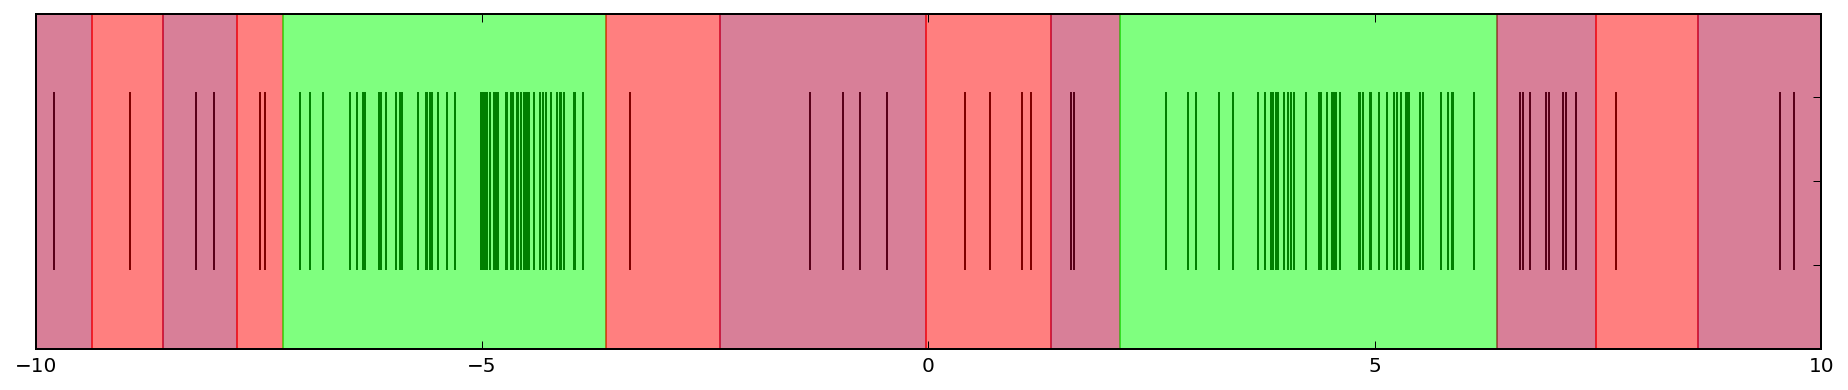

13  SPLITS:
T =  8
Anomalies Fraction =  0.207142857143 %


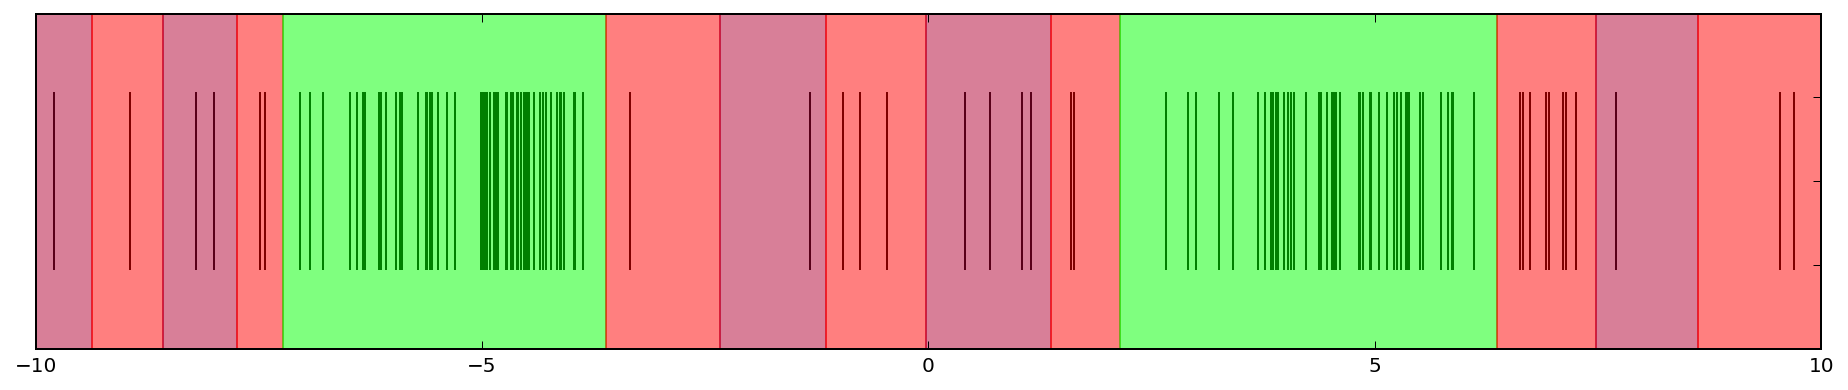

14  SPLITS:
T =  8
Anomalies Fraction =  0.207142857143 %


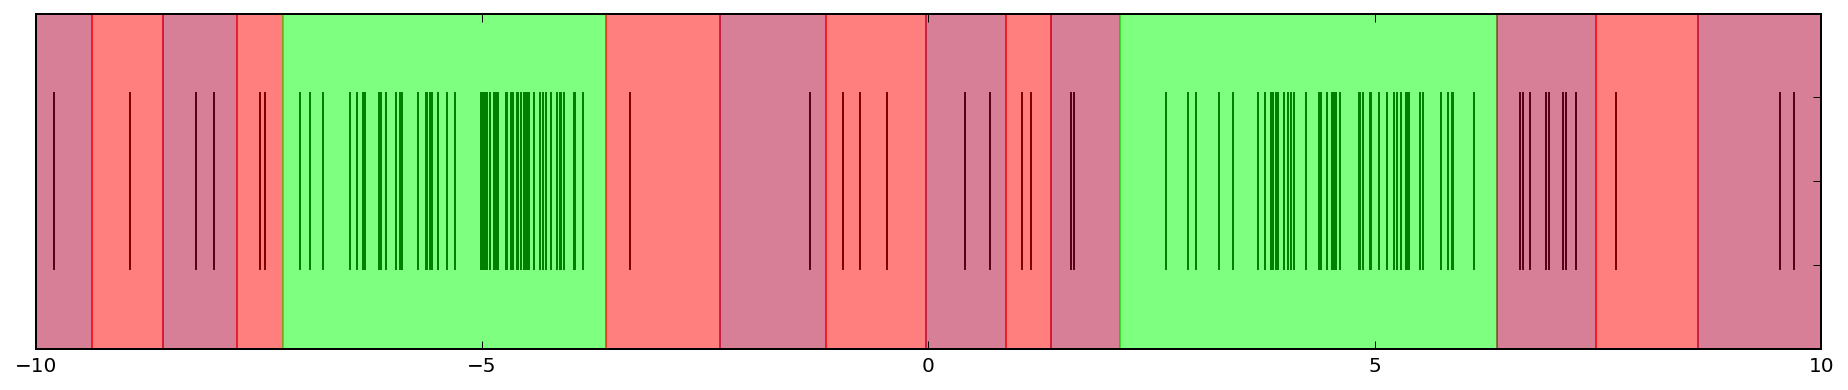

15  SPLITS:
T =  8
Anomalies Fraction =  0.207142857143 %


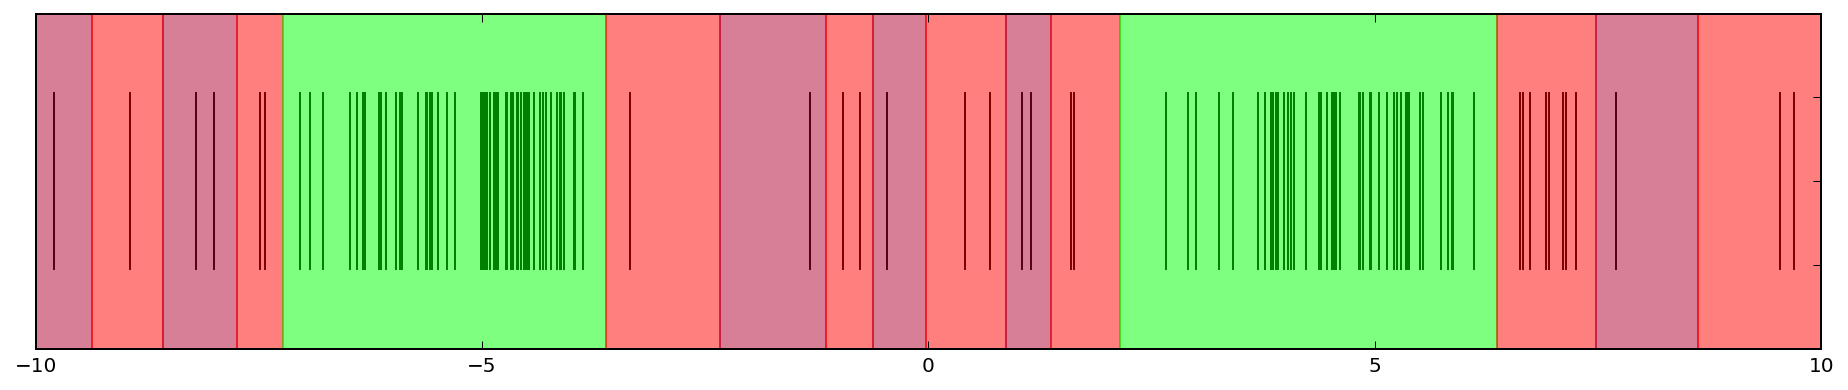

16  SPLITS:
T =  8
Anomalies Fraction =  0.228571428571 %


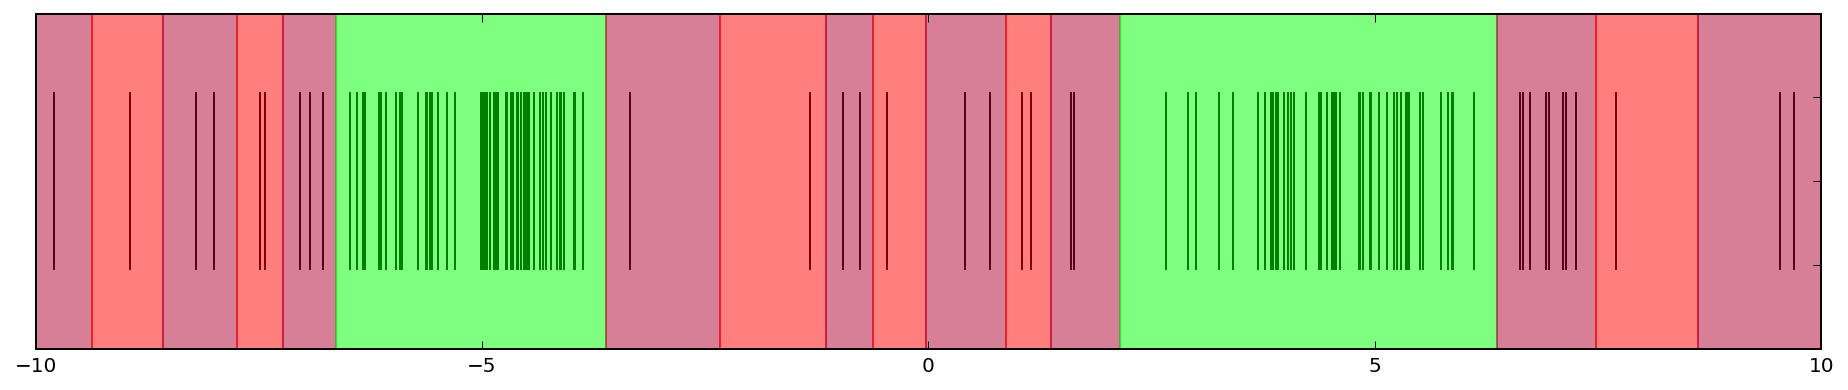

17  SPLITS:
T =  20
Anomalies Fraction =  0.371428571429 %


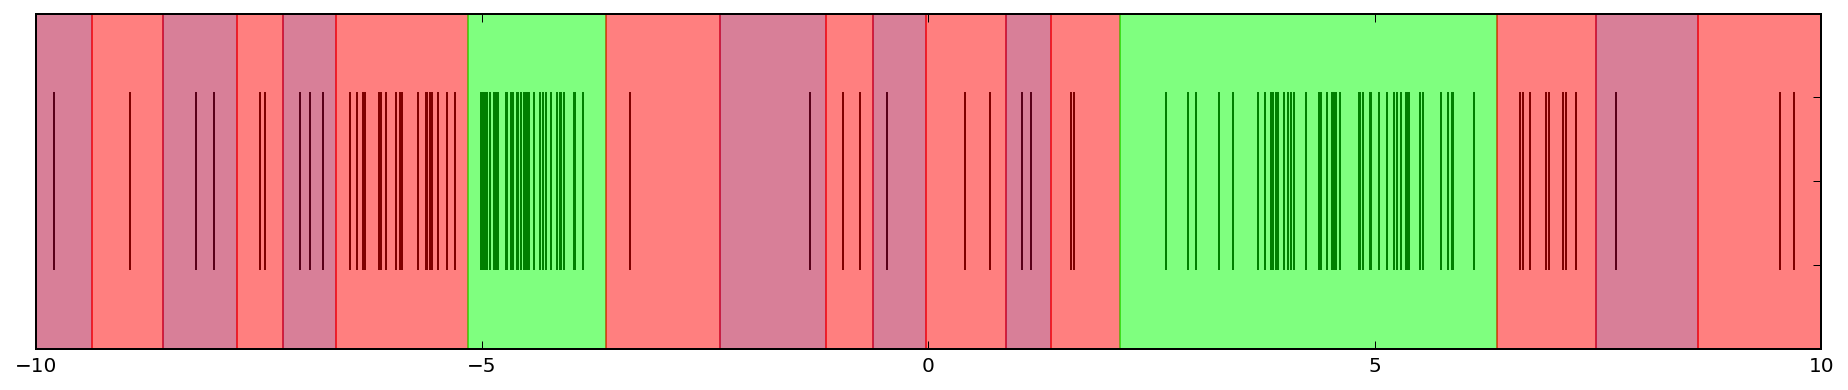

18  SPLITS:
T =  20
Anomalies Fraction =  0.371428571429 %


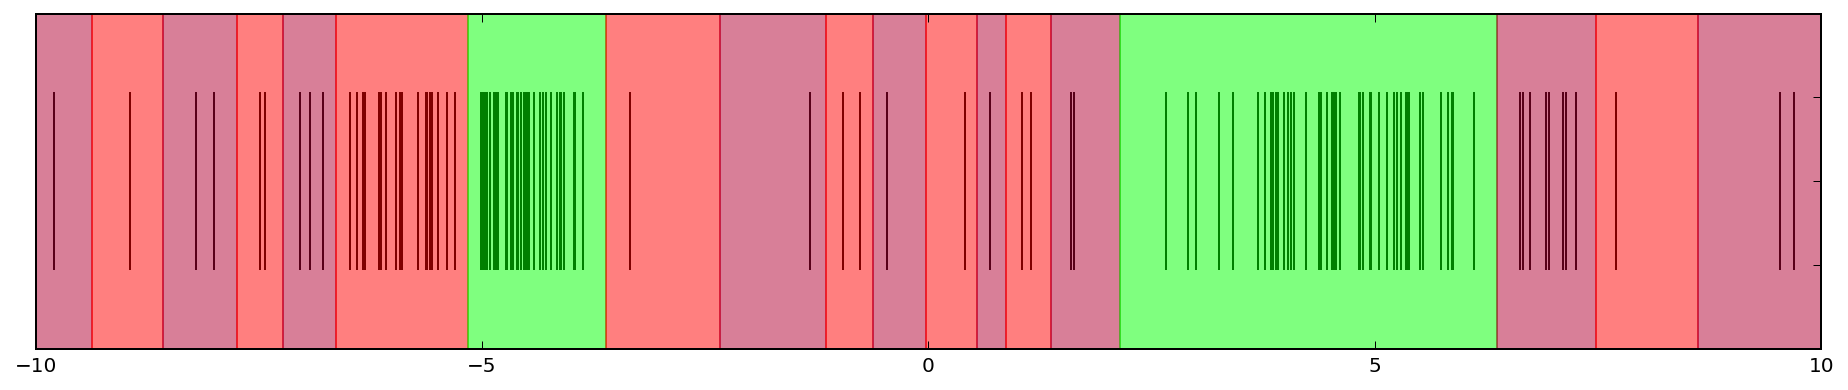

19  SPLITS:
T =  20
Anomalies Fraction =  0.414285714286 %


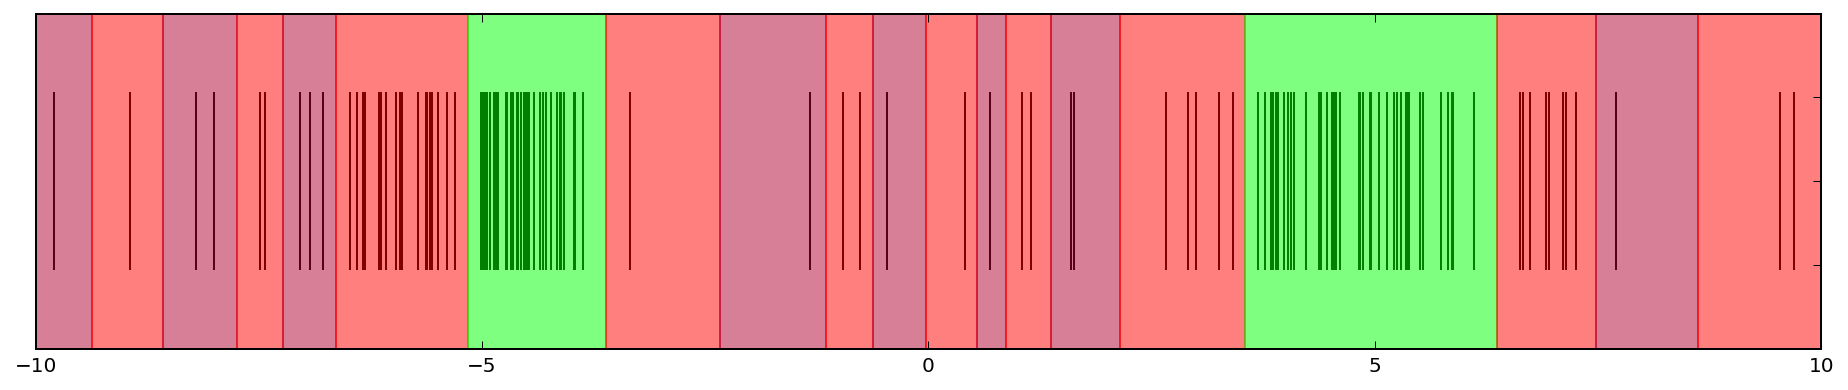

In [39]:
for n_of_splits in range(1, 20):
    print(n_of_splits, " SPLITS:")
    thresholds = (all_points[:-1] + differences / 2)[np.argsort(differences)[::-1][:n_of_splits]]
    n_of_cluster = np.array([all_data > threshold for threshold in thresholds]).sum(axis=0)
    print("T = ", T(n_of_cluster, thresholds))
    print("Anomalies Fraction = ", f(n_of_cluster, thresholds).sum() / len(all_data), "%")
    draw_thr(n_of_cluster, all_points, thresholds)

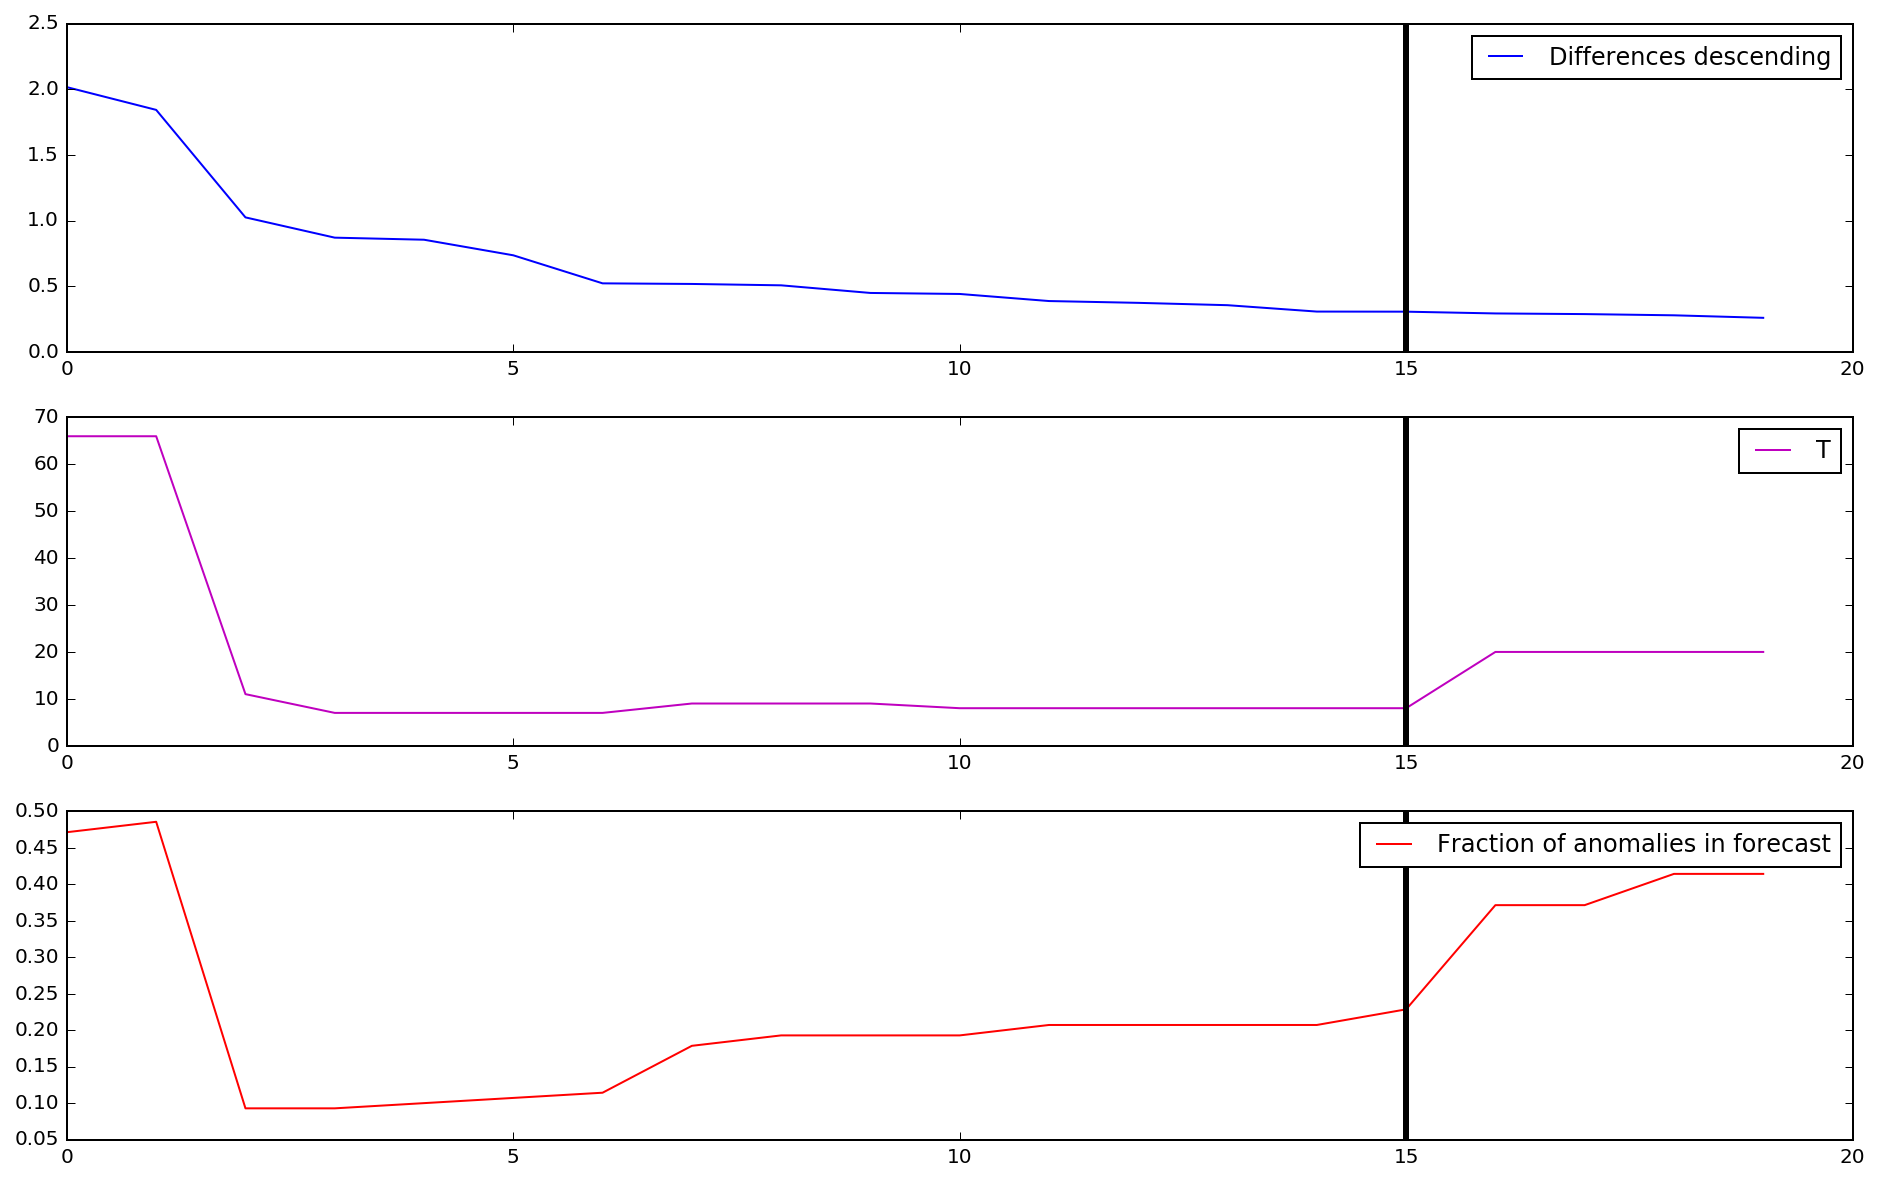

In [40]:
T_dynamics = []
AnomFraction_dynamics = []
for n_of_splits in range(1, 21):
    thresholds = (all_points[:-1] + differences / 2)[np.argsort(differences)[::-1][:n_of_splits]]
    n_of_cluster = np.array([all_data > threshold for threshold in thresholds]).sum(axis=0)
    T_dynamics.append(T(n_of_cluster, thresholds))
    AnomFraction_dynamics.append(f(n_of_cluster, thresholds).sum() / len(all_data))
    
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(311)
ax.plot(np.sort(differences)[::-1][:20])
ax.legend(['Differences descending'])
plt.axvline(x = 15, lw=3, c='black')
ax = fig.add_subplot(312)
ax.plot(T_dynamics, color='m')
ax.legend(['T'])
plt.axvline(x = 15, lw=3, c='black')
ax = fig.add_subplot(313)
ax.plot(AnomFraction_dynamics, color='red')
ax.legend(['Fraction of anomalies in forecast'])
plt.axvline(x = 15, lw=3, c='black')
plt.show(fig)

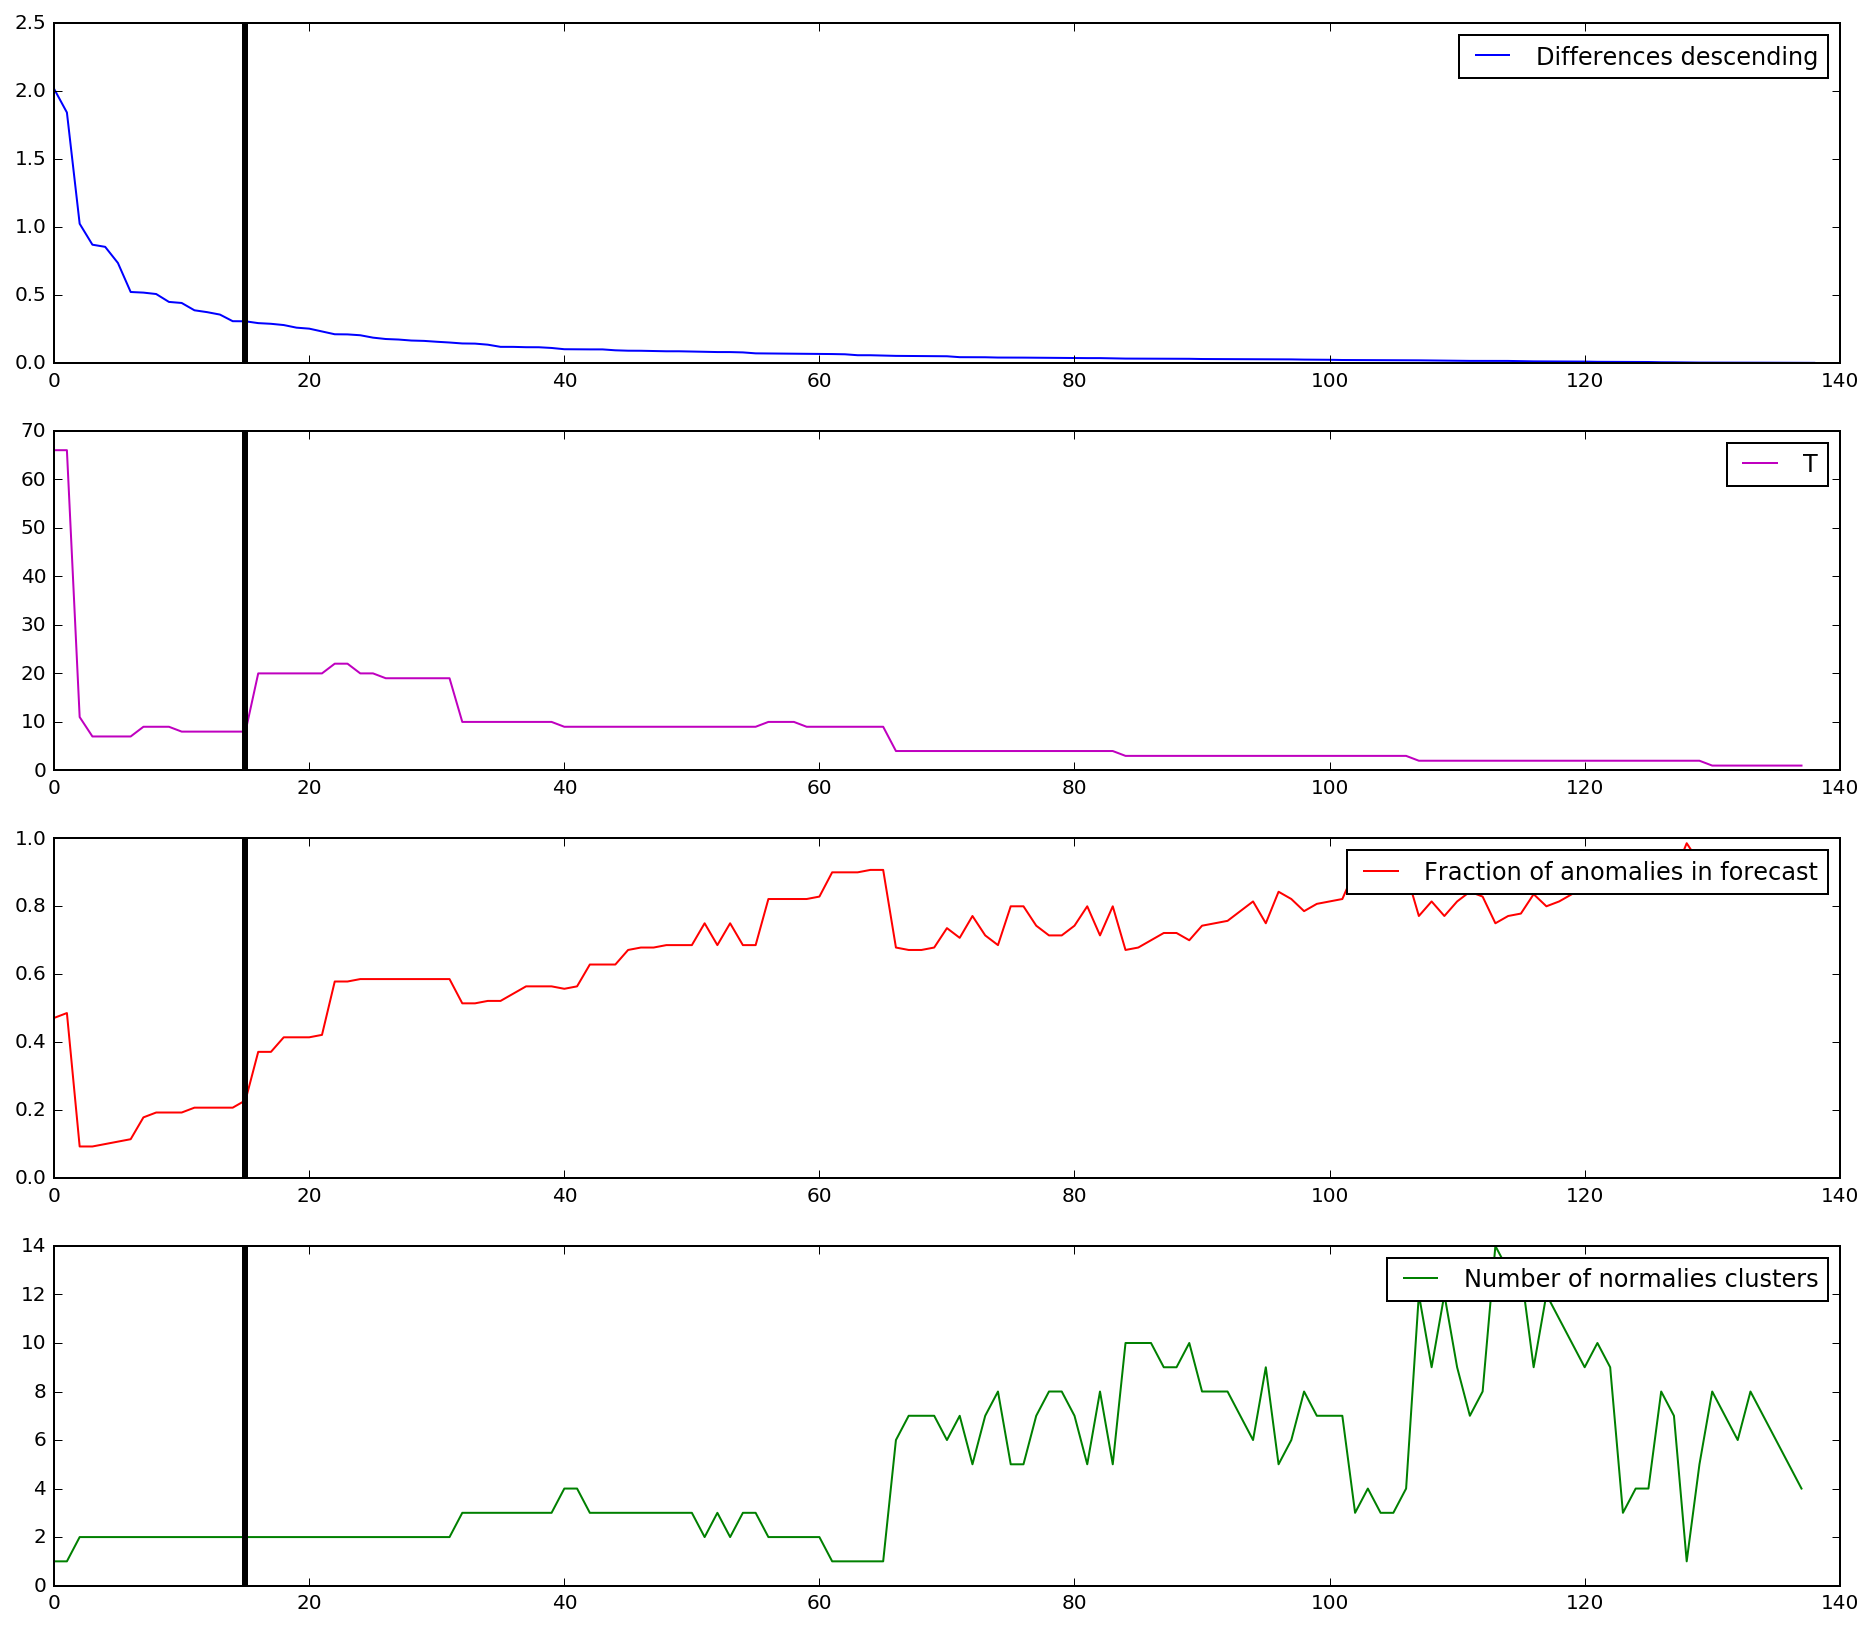

In [41]:
T_dynamics = []
AnomFraction_dynamics = []
N_of_normalies_clusters = []
for n_of_splits in range(1, len(differences)):
    thresholds = (all_points[:-1] + differences / 2)[np.argsort(differences)[::-1][:n_of_splits]]
    n_of_cluster = np.array([all_data > threshold for threshold in thresholds]).sum(axis=0)
    T_dynamics.append(T(n_of_cluster, thresholds))
    AnomFraction_dynamics.append(f(n_of_cluster, thresholds).sum() / len(all_data))
    N_of_normalies_clusters.append(len(get_normals_clusters(n_of_cluster, thresholds)))
    
fig = plt.figure(figsize=(16, 14))
ax = fig.add_subplot(411)
ax.plot(np.sort(differences)[::-1])
ax.legend(['Differences descending'])
plt.axvline(x = 15, lw=3, c='black')
ax = fig.add_subplot(412)
ax.plot(T_dynamics, color='m')
ax.legend(['T'])
plt.axvline(x = 15, lw=3, c='black')
ax = fig.add_subplot(413)
ax.plot(AnomFraction_dynamics, color='red')
ax.legend(['Fraction of anomalies in forecast'])
plt.axvline(x = 15, lw=3, c='black')
ax = fig.add_subplot(414)
ax.plot(N_of_normalies_clusters, color='green')
ax.legend(['Number of normalies clusters'])
plt.axvline(x = 15, lw=3, c='black')
plt.show(fig)

Смысл всех этих рассуждений в том, чтобы стараться не отталкиваться ни от какой априорной информации, хотя она, конечно, необходима. Например, судя по графикам выше можно определить удачный сплит исходя из несильных предположений: например, доля аномалий не больше 50%, а $T < 15$, то есть аномалии образуют кластера не более 15.

Попробуем применить подобные размышления к искусственно прикладной задаче. Возьмём два кластера в трёхмерном пространстве, сделаем шум в случайном количестве, применим isolation forest и посмотрим на anomaly_score

In [42]:
from sklearn.datasets.samples_generator import make_blobs
normal = make_blobs(n_samples=1000, centers=2, n_features=3, random_state=rg)[0]
anomaly = rg.rand(rg.rand() * 1000, 3) * 10

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


In [43]:
from sklearn.ensemble import IsolationForest
all_data = np.vstack([normal, anomaly])
anomaly_score = IsolationForest(random_state=rg).fit(all_data).decision_function(all_data)

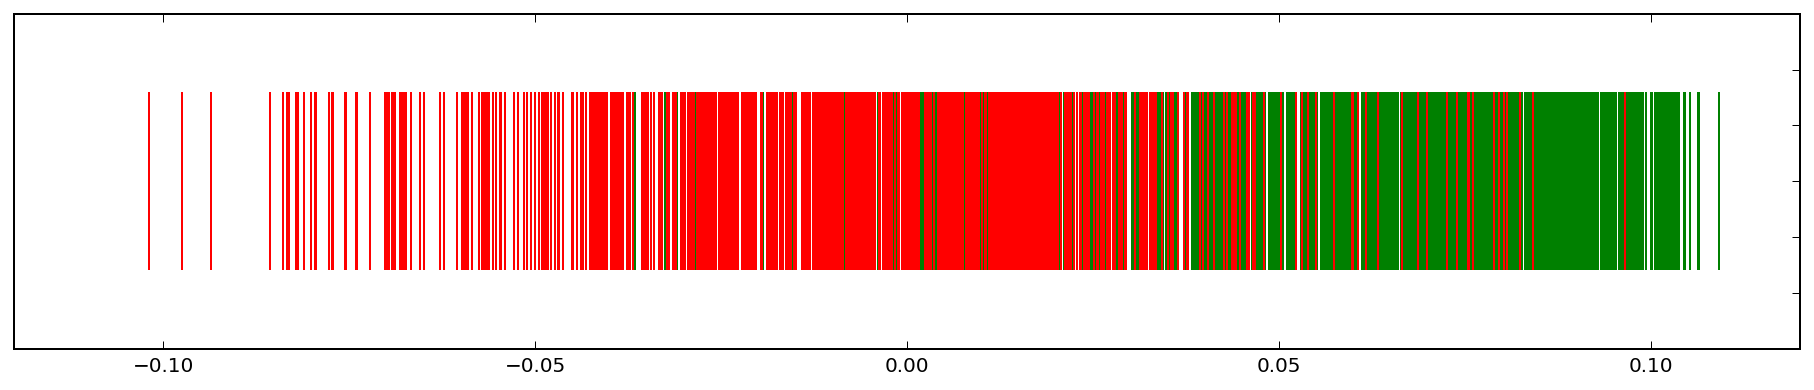

In [44]:
show(anomaly_score[:1000], anomaly_score[1000:], 0.12)

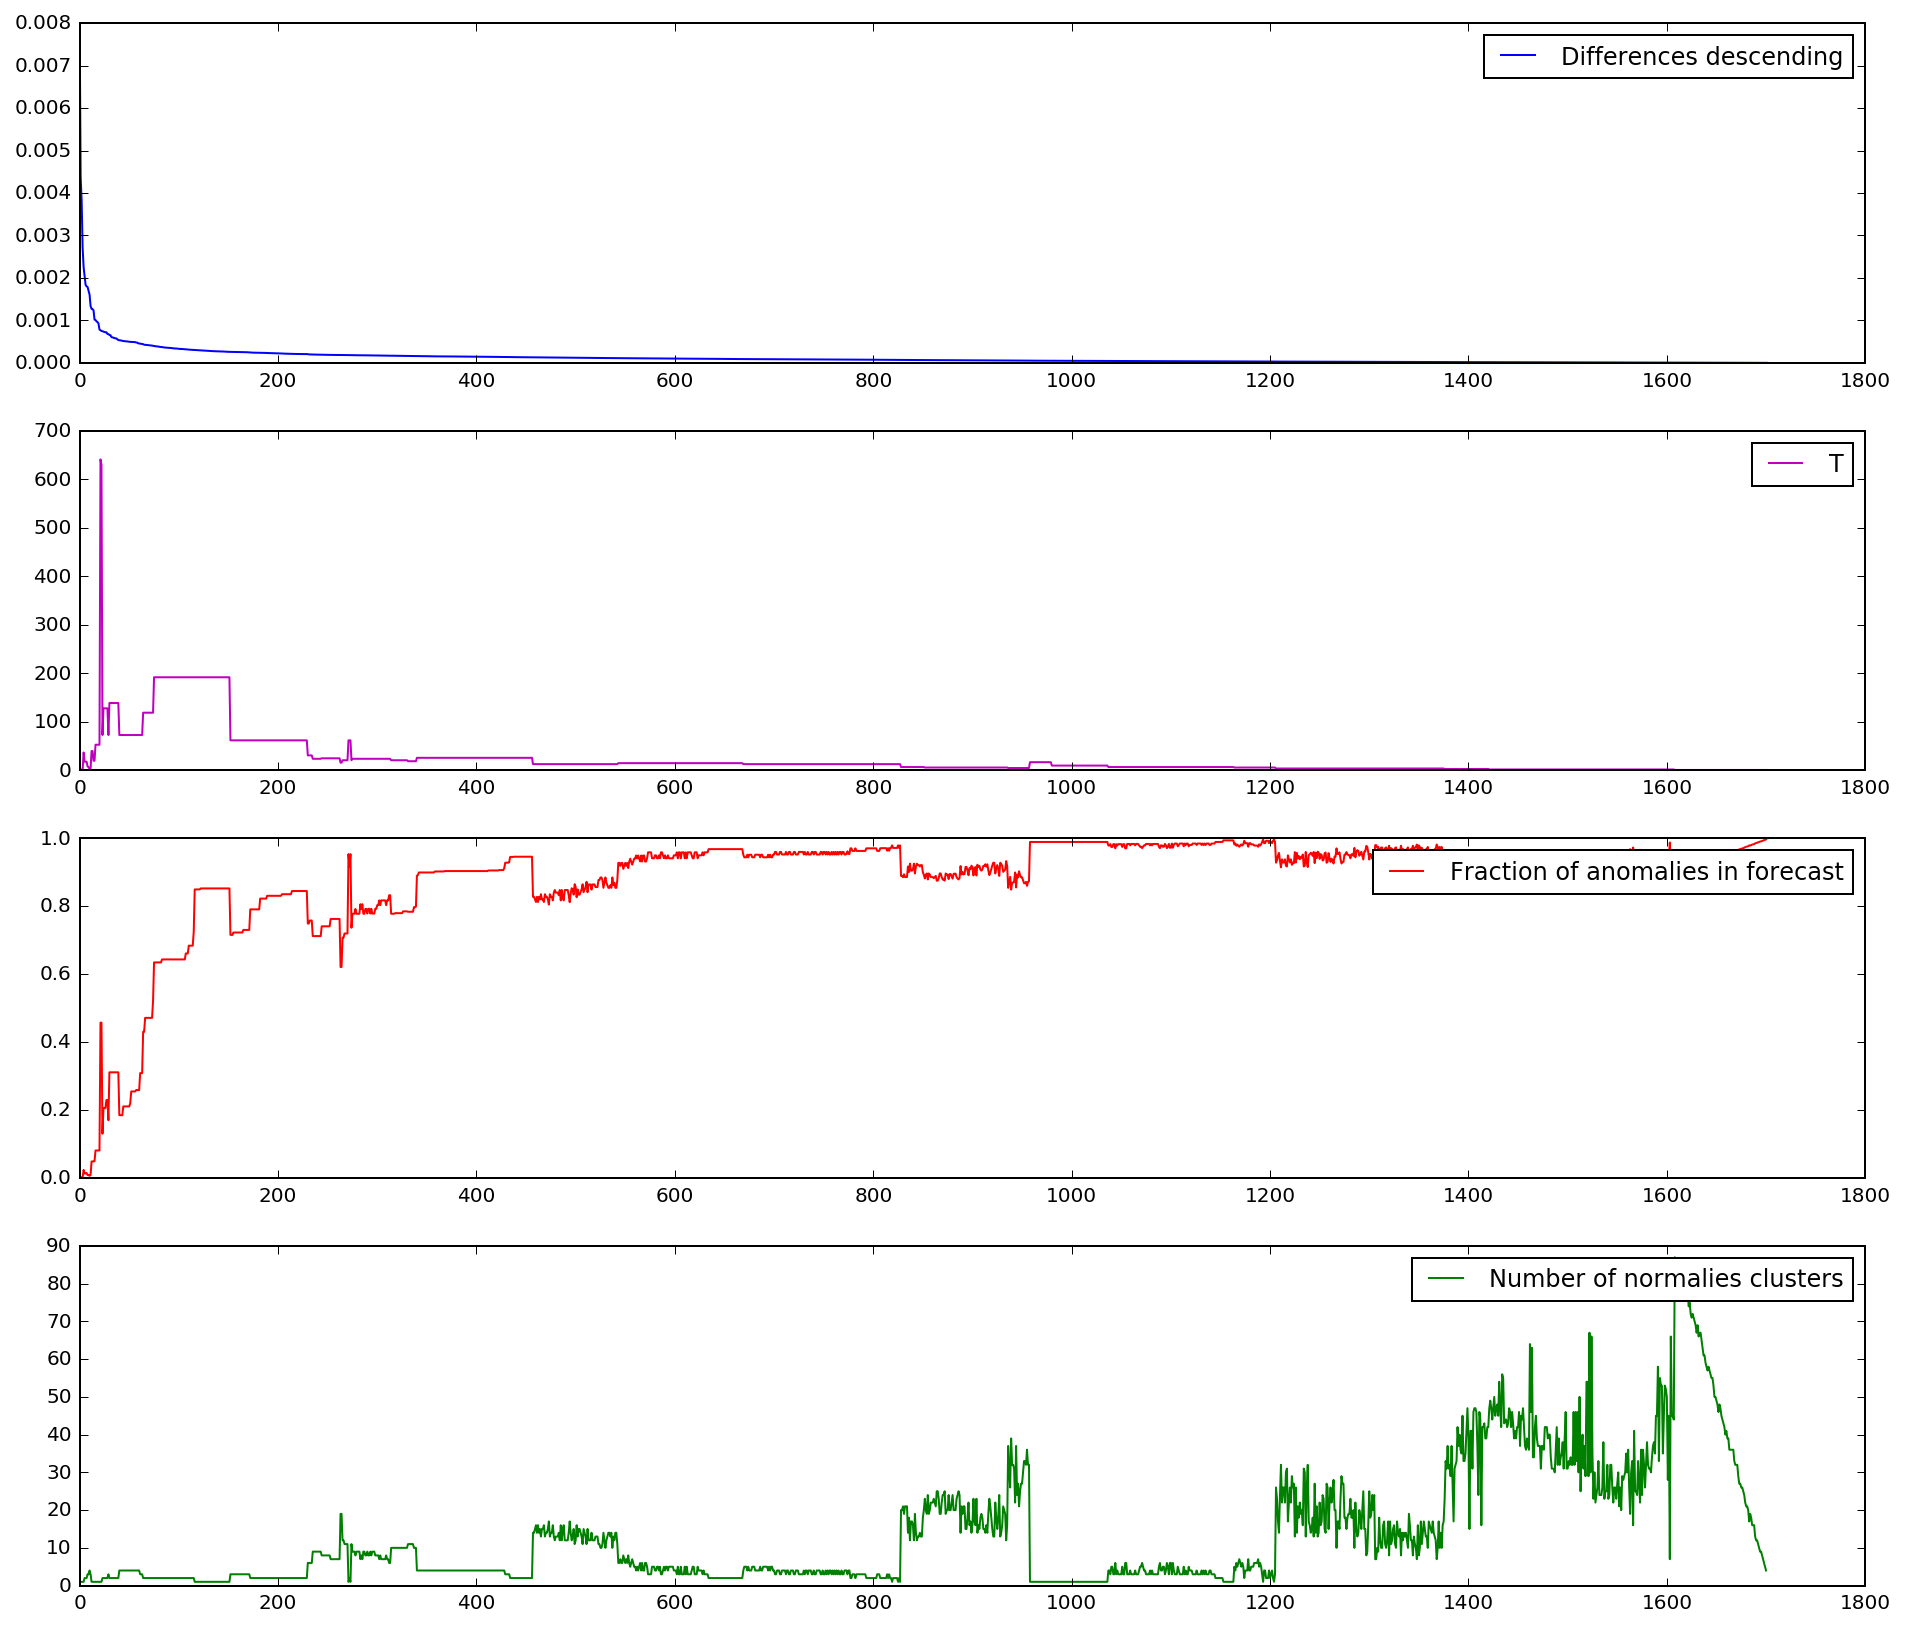

In [45]:
all_points = np.sort(anomaly_score)
differences = all_points[1:] - all_points[:-1]

T_dynamics = []
AnomFraction_dynamics = []
N_of_normalies_clusters = []
for n_of_splits in range(1, len(differences)):
    thresholds = (all_points[:-1] + differences / 2)[np.argsort(differences)[::-1][:n_of_splits]]
    n_of_cluster = np.array([anomaly_score > threshold for threshold in thresholds]).sum(axis=0)
    T_dynamics.append(T(n_of_cluster, thresholds))
    AnomFraction_dynamics.append(f(n_of_cluster, thresholds).sum() / len(all_data))
    N_of_normalies_clusters.append(len(get_normals_clusters(n_of_cluster, thresholds)))
    
fig = plt.figure(figsize=(16, 14))
ax = fig.add_subplot(411)
ax.plot(np.sort(differences)[::-1])
ax.legend(['Differences descending'])
ax = fig.add_subplot(412)
ax.plot(T_dynamics, color='m')
ax.legend(['T'])
ax = fig.add_subplot(413)
ax.plot(AnomFraction_dynamics, color='red')
ax.legend(['Fraction of anomalies in forecast'])
ax = fig.add_subplot(414)
ax.plot(N_of_normalies_clusters, color='green')
ax.legend(['Number of normalies clusters'])
plt.show(fig)

Ну вот я знаю, что anomaly_fraction < 0.5, например, значит, я уже знаю, что брать надо до 

In [46]:
(np.array(AnomFraction_dynamics) < 0.5).sum()

74

до 74-ёх сплитов. Конечно, этот ход не учитывает, что мы не гнушимся завышать fpr, а значит, в нашем anomaly_fraction "большая" доля неаномалий, поэтому возьмём с запасом и рассмотрим первые 100 сплитов 

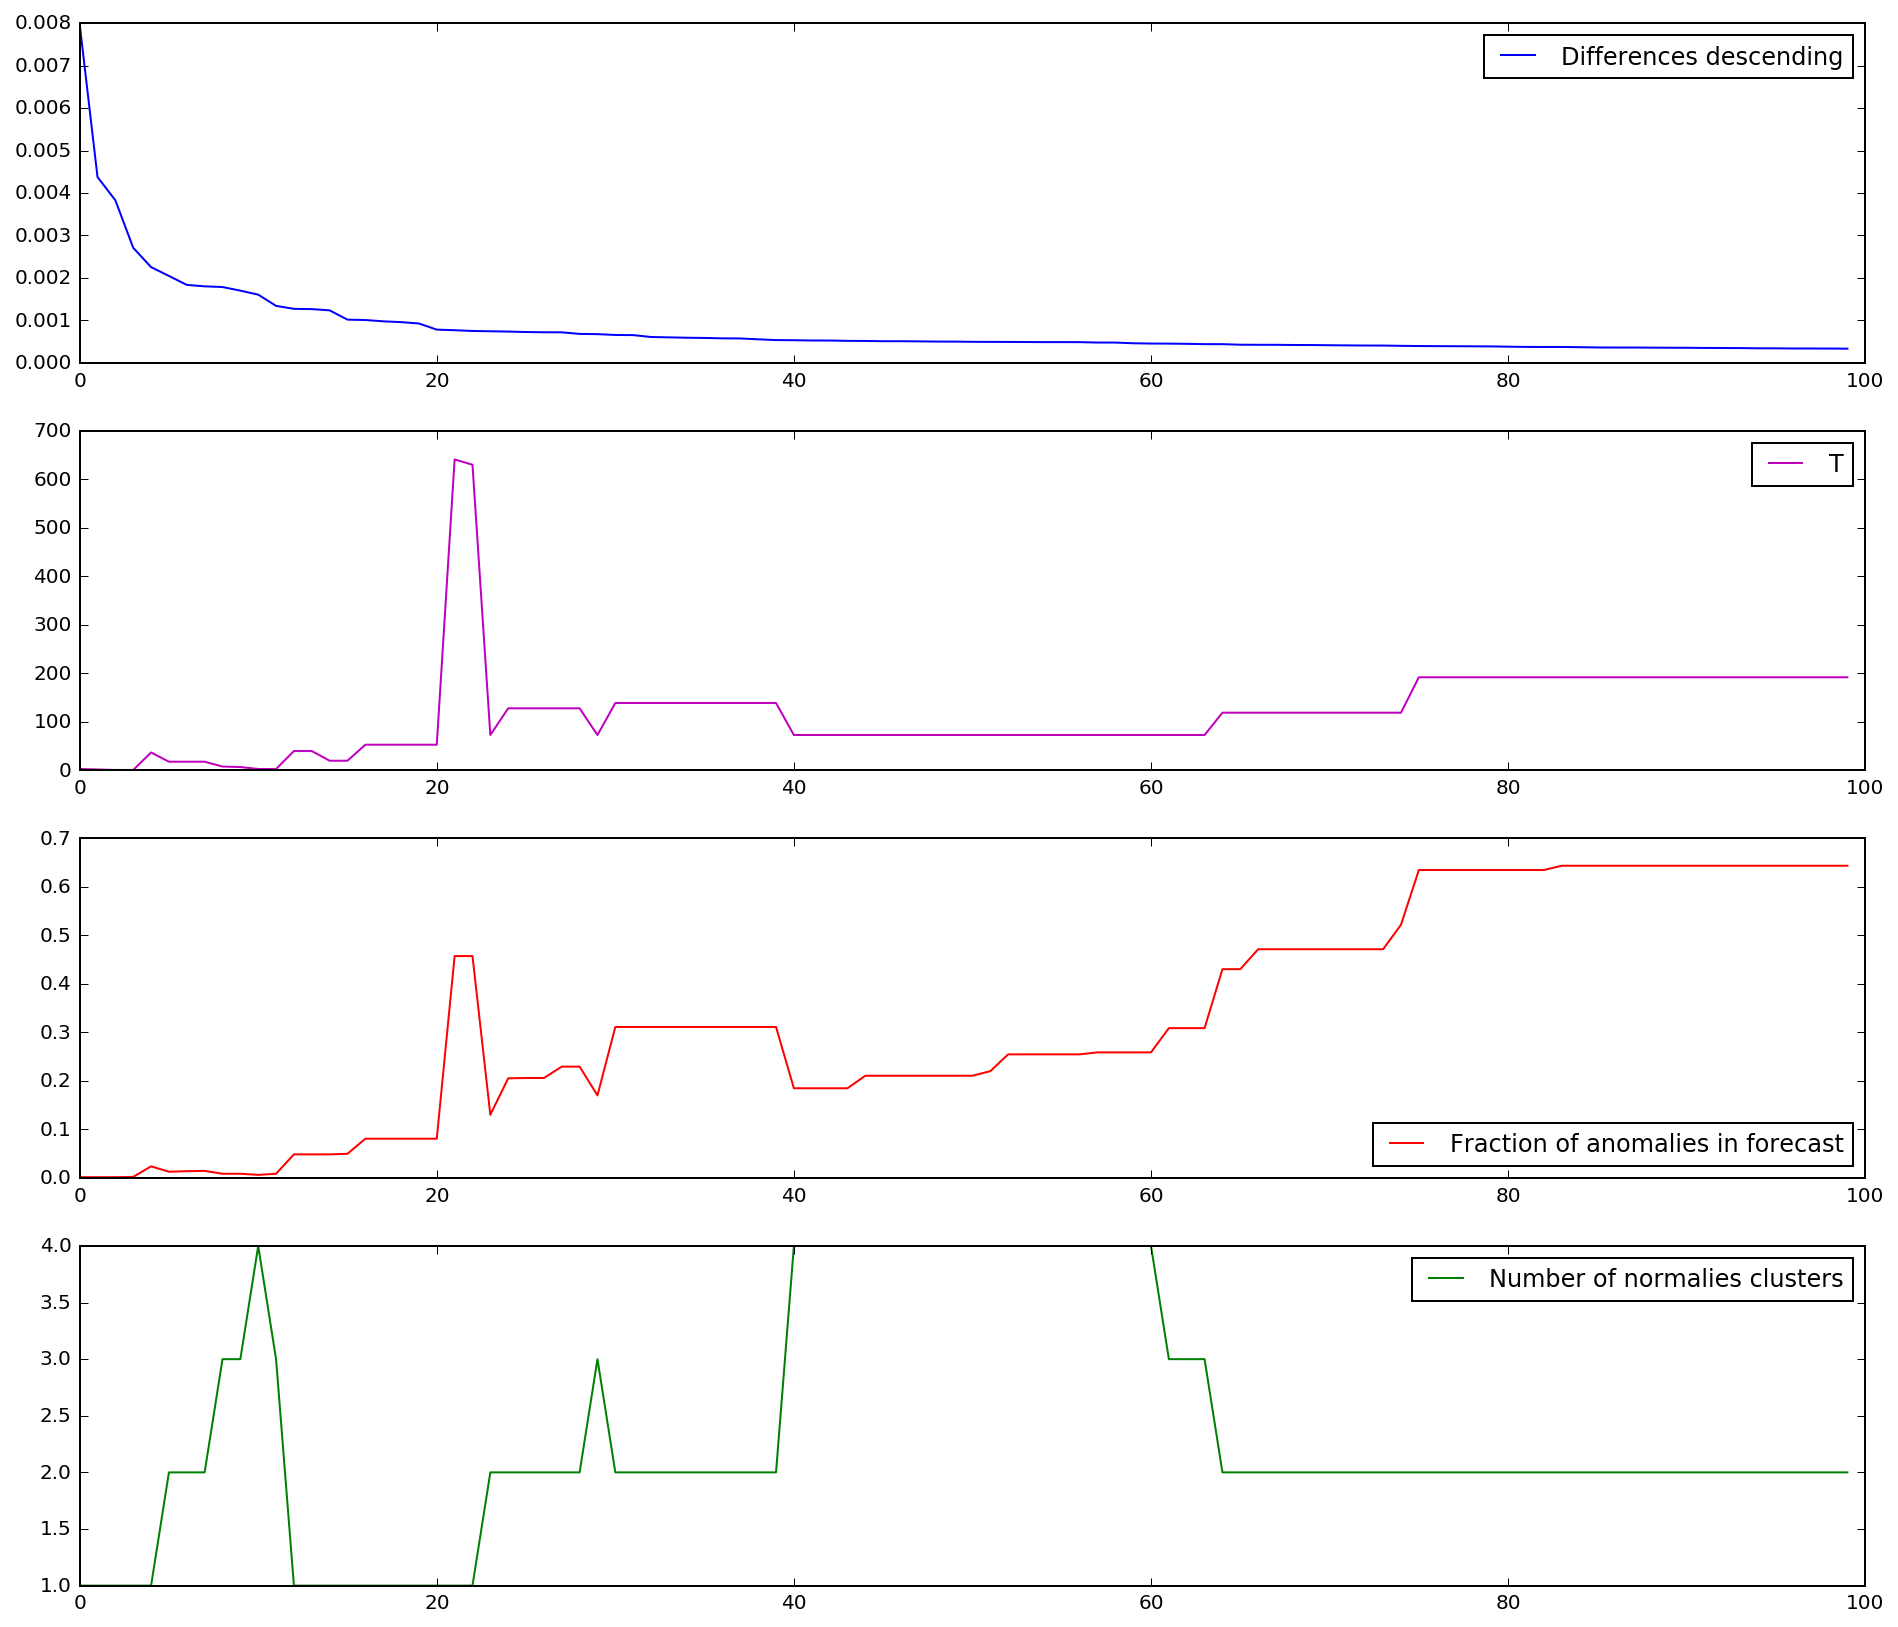

In [47]:
fig = plt.figure(figsize=(16, 14))
ax = fig.add_subplot(411)
ax.plot(np.sort(differences)[::-1][:100])
ax.legend(['Differences descending'])
ax = fig.add_subplot(412)
ax.plot(T_dynamics[:100], color='m')
ax.legend(['T'])
ax = fig.add_subplot(413)
ax.plot(AnomFraction_dynamics[:100], color='red')
ax.legend(['Fraction of anomalies in forecast'], loc=4)
ax = fig.add_subplot(414)
ax.plot(N_of_normalies_clusters[:100], color='green')
ax.legend(['Number of normalies clusters'])
plt.show(fig)

Как я рассуждаю: первый плохой сплит рубит хороший кластер нормалей как-то неправильно. Одна из половинок этого кластера нормалей ложно объявляется кластером аномалий, соответственно повышается $T$ и доля аномалий. Ещё я знаю, что речь идёт об anomaly_score и поэтому количество кластеров не должно быть высоким. Вариантов уже не очень много, первый нехороший сплит либо 60 с хвостиком, там где кластеров нормалей упало с 3 до 2 (но тогда в ответе кластеров 3, что смущает, судя по графику это не стабильная ситуация), либо где-то те самые 75, где AnomalyFraction и T резко скаканули.

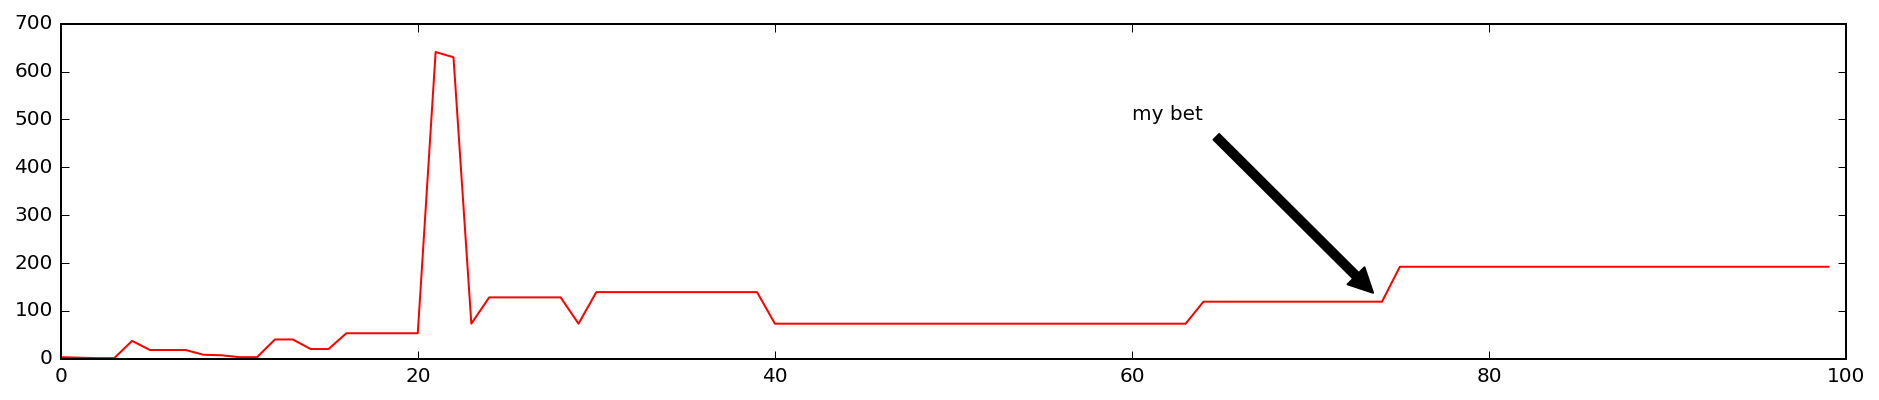

In [48]:
fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot(T_dynamics[:100], color='red')
ax.annotate('my bet', xy=(74, T_dynamics[74]), xytext=(60, 500),
            arrowprops=dict(facecolor='black', shrink=0.05))

Да, предположим, нужно сделать 75 сплитов (на графике они с нуля нумеруются...)

In [49]:
thresholds = (all_points[:-1] + differences / 2)[np.argsort(differences)[::-1][:75]]
n_of_cluster = np.array([anomaly_score > threshold for threshold in thresholds]).sum(axis=0)
y = np.append(np.zeros((1000)), np.ones((len(all_data) - 1000)))
score(f(n_of_cluster, thresholds), y)

precision =  0.518560179978
recall =  0.655761024182
f-measure =  0.579145728643


0.57914572864321601

чёт совсем не угадал, а какой правильный ответ?

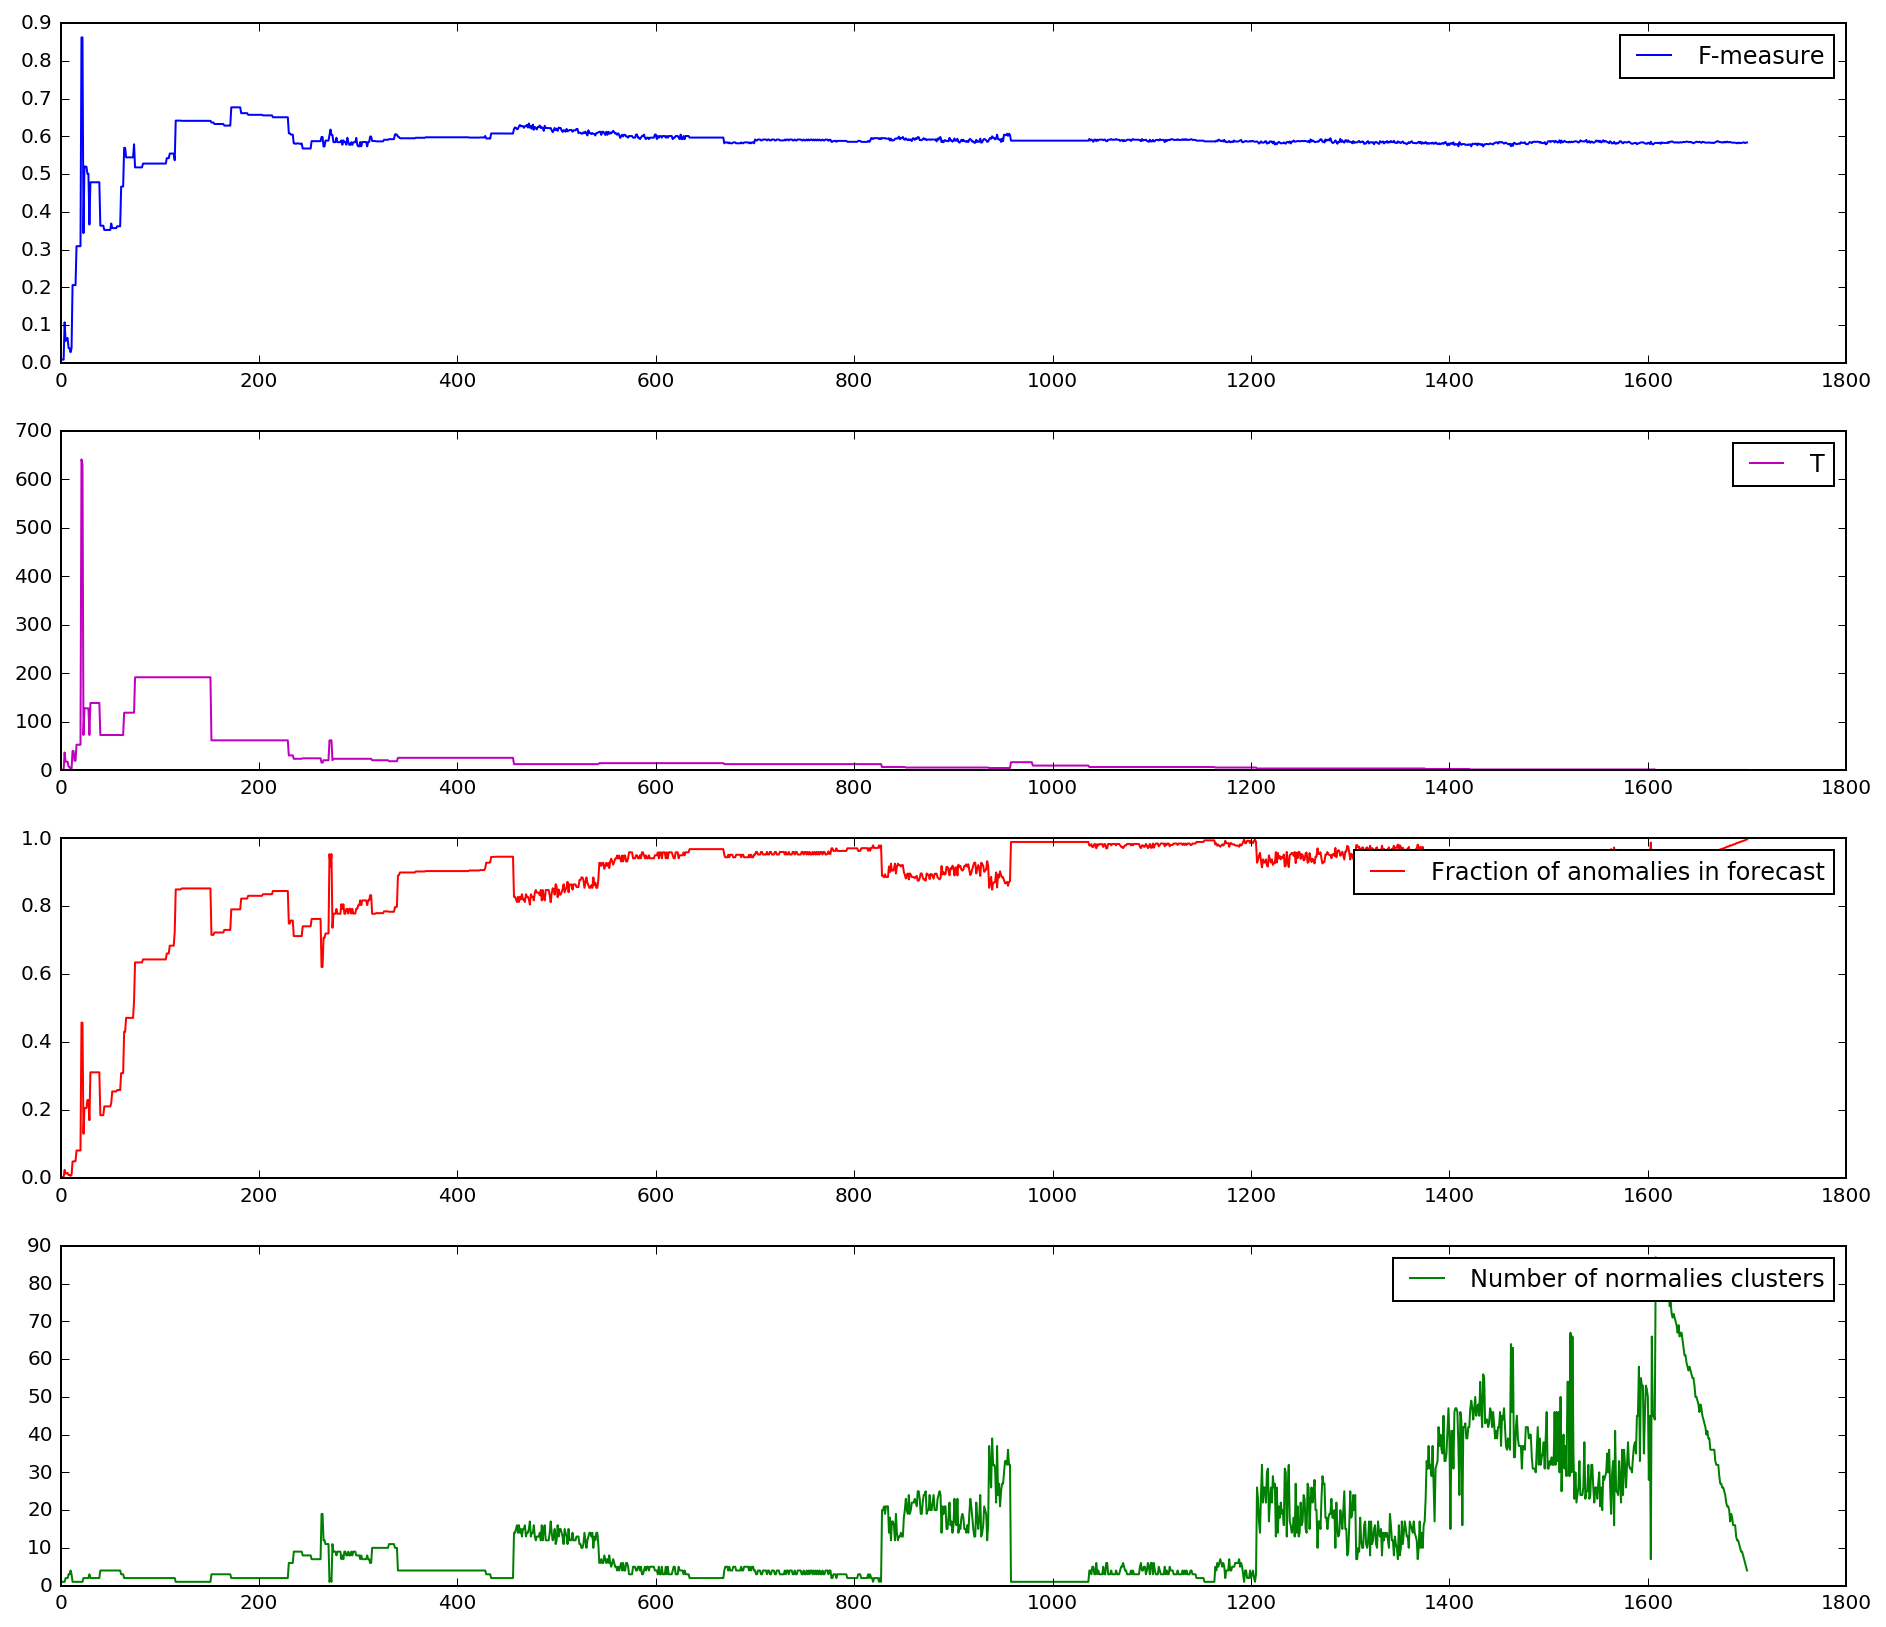

In [50]:
all_points = np.sort(anomaly_score)
differences = all_points[1:] - all_points[:-1]

T_dynamics = []
AnomFraction_dynamics = []
N_of_normalies_clusters = []
F_score = []
for n_of_splits in range(1, len(differences)):
    thresholds = (all_points[:-1] + differences / 2)[np.argsort(differences)[::-1][:n_of_splits]]
    n_of_cluster = np.array([anomaly_score > threshold for threshold in thresholds]).sum(axis=0)
    T_dynamics.append(T(n_of_cluster, thresholds))
    AnomFraction_dynamics.append(f(n_of_cluster, thresholds).sum() / len(all_points))
    N_of_normalies_clusters.append(len(get_normals_clusters(n_of_cluster, thresholds)))
    F_score.append(score(f(n_of_cluster, thresholds), y, verbose=False))
    
fig = plt.figure(figsize=(16, 14))
ax = fig.add_subplot(411)
ax.plot(F_score)
ax.legend(['F-measure'])
ax = fig.add_subplot(412)
ax.plot(T_dynamics, color='m')
ax.legend(['T'])
ax = fig.add_subplot(413)
ax.plot(AnomFraction_dynamics, color='red')
ax.legend(['Fraction of anomalies in forecast'])
ax = fig.add_subplot(414)
ax.plot(N_of_normalies_clusters, color='green')
ax.legend(['Number of normalies clusters'])
plt.show(fig)

In [51]:
thresholds = (all_points[:-1] + differences / 2)[np.argsort(differences)[::-1][:22]]
n_of_cluster = np.array([anomaly_score > threshold for threshold in thresholds]).sum(axis=0)
y = np.append(np.zeros((1000)), np.ones((len(all_data) - 1000)))
score(f(n_of_cluster, thresholds), y)

precision =  0.82028241335
recall =  0.908961593172
f-measure =  0.862348178138


0.86234817813765186

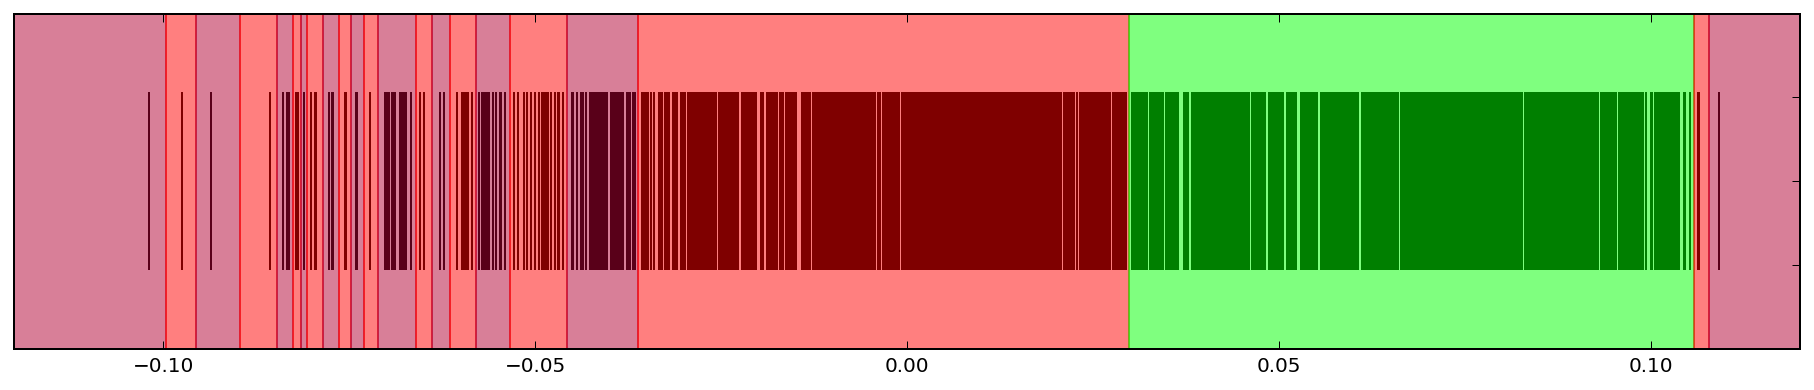

In [52]:
draw_thr(n_of_cluster, all_points, thresholds, 0.12)

Окей, а на что я поставил?

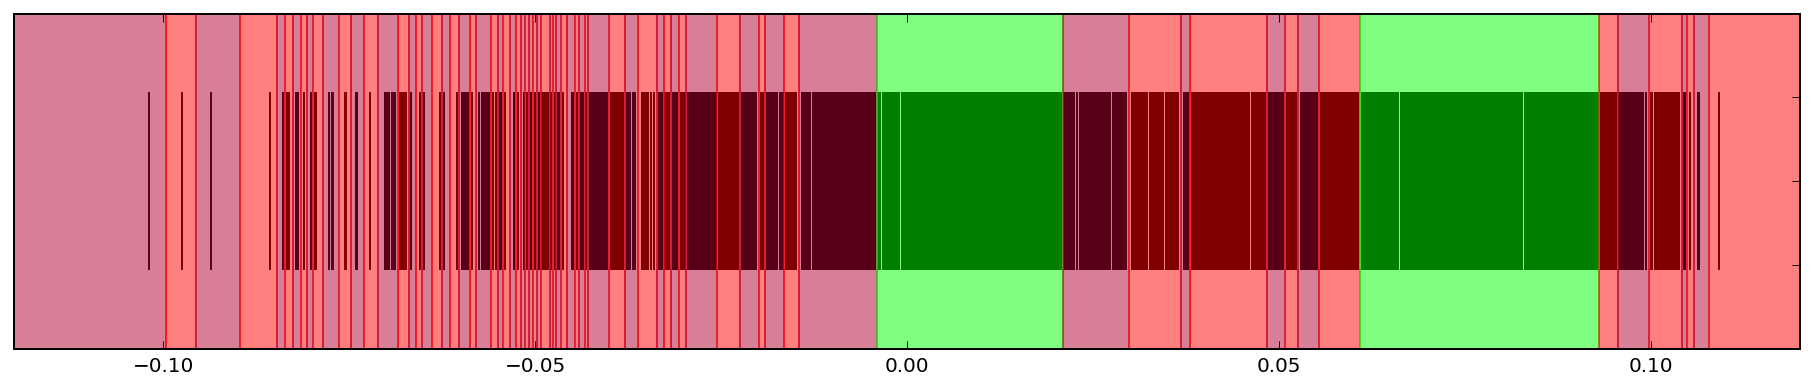

In [53]:
thresholds = (all_points[:-1] + differences / 2)[np.argsort(differences)[::-1][:75]]
n_of_cluster = np.array([anomaly_score > threshold for threshold in thresholds]).sum(axis=0)
y = np.append(np.zeros((1000)), np.ones((len(all_data) - 1000)))
draw_thr(n_of_cluster, all_points, thresholds, 0.12)

Нда, надо было смотреть на картинки... Ну хорошо, а если не мудрить и двигать по порогу, то сколько теоретически можно было бы выжать?

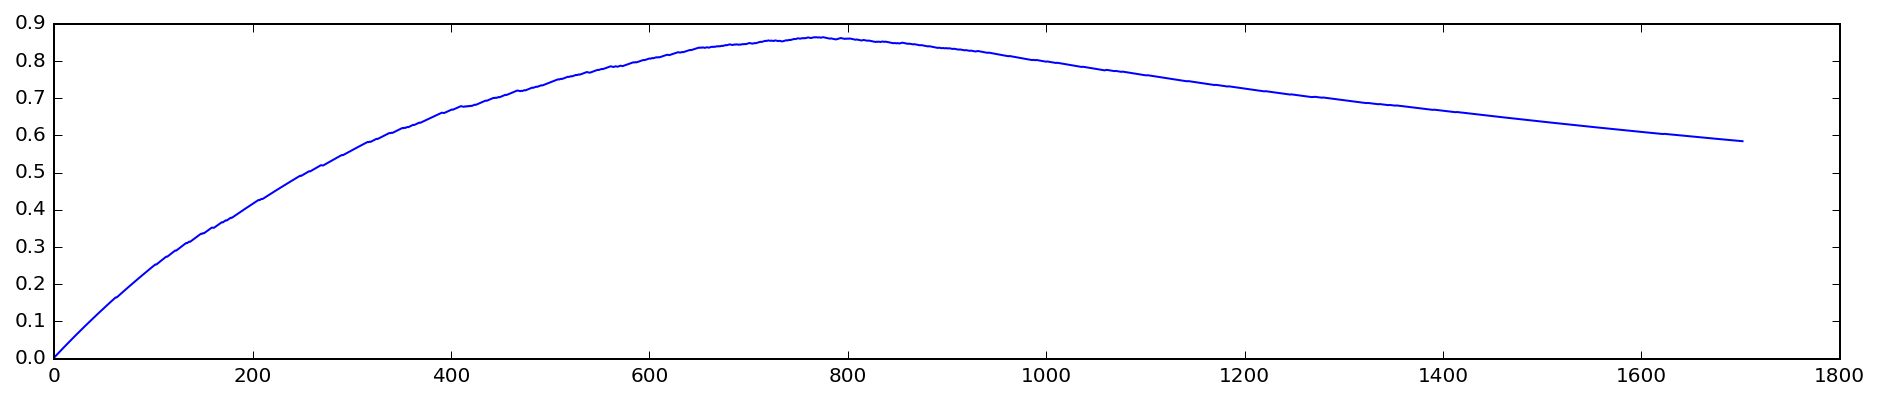

In [54]:
f_meas = []
for i in np.sort(anomaly_score):
    f_meas.append(score(anomaly_score <= i, y, verbose=False))
plt.plot(f_meas)

In [55]:
np.array(f_meas).max()

0.86413043478260876

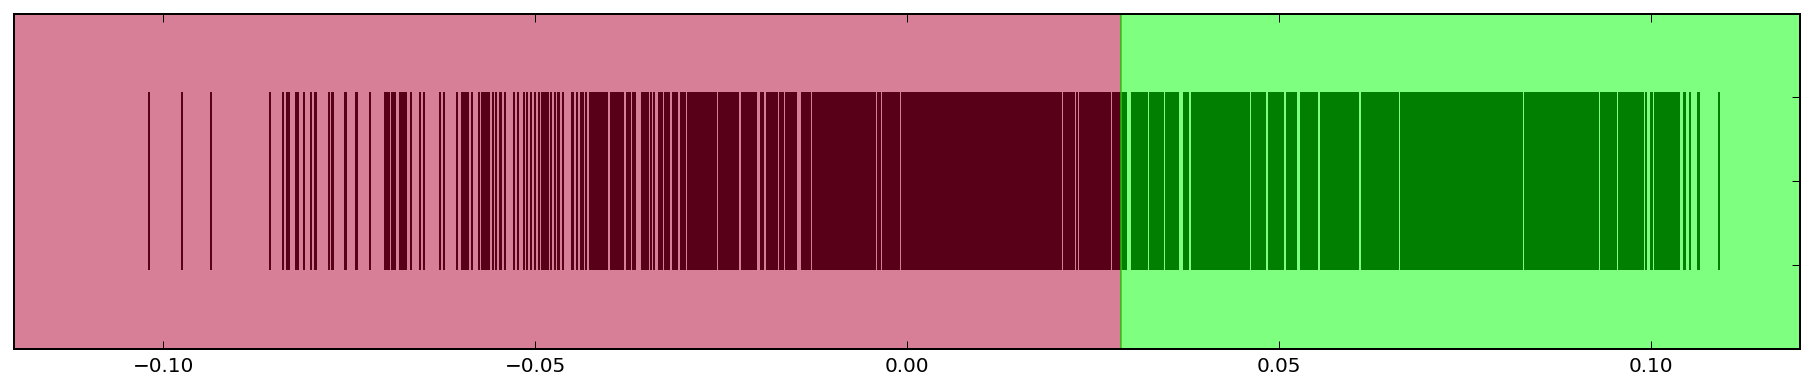

In [56]:
currentAxis = plt.gca()
start = all_points.min() - 1

currentAxis.add_patch(plt.Rectangle((start, -1), np.sort(anomaly_score)[768] - start, 2, color=(0.7, 0, 0.2, 0.5)))
currentAxis.add_patch(plt.Rectangle((np.sort(anomaly_score)[768], -1), all_points.max() + 1 - np.sort(anomaly_score)[768], 2, color=(0, 1, 0, 0.5)))

plt.scatter(all_points, np.zeros_like(all_points), marker='|', c='black', s=8000)
plt.tick_params(axis='y', left='off', labelleft='off')
plt.ylim(-1, 1)
plt.xlim(-0.12, 0.12)
plt.show()

Впрочем, это со скидкой на то, что "сколько нужно двигать" совершенно неясно...

Мораль примерно следующая. Отсутствие априорной информации делает задачу нерешаемой даже в одномерном случае. Какие-то простейшие предположения уже дают возможность как-то двигаться и получать какие-то результаты, однако как следует правильно размышлять (имея самый-самый минимум предположений на руках) - пока неясно. 

Важно, что в случае, когда речь идёт об anomaly_score, нужно учитывать не только те вещи, о которых я писал выше, но и тот факт, что "нормалии скорее правее", а "аномалии скорее левее". И, конечно же, надежда на то, что оптимально иметь только один кластер нормалей, может существенно упростить алгоритм и избавить от сомнительных телодвижений.